In [1]:
#  numpy==1.21.5 statsmodels==0.13.2 pandas==1.4.0 numba==0.55.1

import warnings
import numpy as np
import random
import pandas as pd
import statsmodels.api as sm
import pyarrow as pa
from pyarrow import csv
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
pd.options.mode.chained_assignment = None 
from scipy.stats import f
import numpy as np
from numpy.linalg import inv
import itertools
import random
import random
import itertools
import matplotlib.pyplot as plt

# 1 & 2. Introduction and Theory Review

For theoretical aspects and introduction read the paper

# 3. Autocorrelations in returns of equity factors

## 3.1 Read Data

### 3.1.1 Dataset 1 (in %)

**Weights**

Compute weights of different regions by market cap. The total regions are developed markets excluding europe.

In [2]:
#Read Data
weights=pd.read_csv("Weights.csv",skiprows=4,delimiter=",")
weights=weights.drop(["Country Code","Indicator Name","Indicator Code","Unnamed: 68"],axis=1)
weights=weights.transpose()
weights.columns = weights.iloc[0]
weights = weights[1:]
weights = weights[weights.index >= "1989"]

#Select Developed Market Countries
asia_pac_w=weights[["Australia","Hong Kong SAR, China","Japan","New Zealand","Singapore"]]
north_am_w=weights[["Canada","United States"]]
eur_w=weights[["Austria","Belgium","Switzerland","Germany","Denmark","Spain","Finland","France","United Kingdom","Greece","Ireland","Italy","Netherlands","Norway","Portugal","Sweden"]]

#Compute Total Cap (Ex Europe)
total_cap=asia_pac_w.sum(axis=1)+north_am_w.sum(axis=1) #+eur_w.sum(axis=1) 

#Generate a DataFrame with the Market Weight for different regions
total_weights=pd.DataFrame(index=total_cap.index)
total_weights["Asia Pacific"]=asia_pac_w.sum(axis=1)/total_cap
total_weights["Asia Pacific ExJapan"]=asia_pac_w.drop(columns=["Japan"]).sum(axis=1)/total_cap
total_weights["Japan"]=asia_pac_w[["Japan"]].sum(axis=1)/total_cap
total_weights["North America"]=north_am_w.sum(axis=1)/total_cap
total_weights["US"]=weights[["United States"]].sum(axis=1)/total_cap
total_weights["Canada"]=weights[["Canada"]].sum(axis=1)/total_cap
total_weights= total_weights.dropna(axis=0)

#Make 2023 year = 2022
last_row = total_weights.iloc[-1]
new_row = pd.DataFrame([last_row], index=["2023"])
total_weights = total_weights.append(new_row)

Read factors from Fama French and AQR website, combine them in a DataFrame (expressed as montlhy % return) and compute mean statistics.

**5 Classical Factors**

Europe

In [3]:
#read europe 5f
europe_5f=pd.read_csv("Europe_5_Factors.csv",skiprows=6,index_col=0).drop(columns=["RF"])
europe_5f=europe_5f/100
europe_5f=europe_5f[europe_5f.index<=202312]
rf=pd.read_csv("Europe_5_Factors.csv",skiprows=6,index_col=0)[["RF"]]

Global

In [4]:
#read asia and north america
japan=pd.read_csv("Japan_5_Factors.csv",skiprows=6,delimiter=",",index_col=0, skip_blank_lines=False).drop(columns=["Mkt-RF","RF"])
japan=japan/100
asia_exjap=pd.read_csv("Asia_Pacific_ex_Japan_5_Factors.csv",skiprows=6,delimiter=",",index_col=0, skip_blank_lines=False).drop(columns=["Mkt-RF","RF"])
asia_exjap=asia_exjap/100
north_america=pd.read_csv("North_America_5_Factors.csv",skiprows=6,delimiter=",",index_col=0, skip_blank_lines=False).drop(columns=["Mkt-RF","RF"])
north_america=north_america/100

#wegiht portfolios
japan_weighted=japan.copy()

for index, row in japan_weighted.iterrows():
    year=int(str(index)[:4])-1
    weight=total_weights["Japan"].loc[str(year)]
    japan_weighted.loc[index]=japan_weighted.loc[index]*weight
    
asia_exjap_weighted=asia_exjap.copy()
for index, row in asia_exjap.iterrows():
    year=int(str(index)[:4])-1
    weight=total_weights["Asia Pacific ExJapan"].loc[str(year)]
    asia_exjap_weighted.loc[index]=asia_exjap_weighted.loc[index]*weight
    
north_america_weighted=north_america.copy()
for index, row in north_america_weighted.iterrows():
    year=int(str(index)[:4])-1
    weight=total_weights["North America"].loc[str(year)]
    north_america_weighted.loc[index]=north_america_weighted.loc[index]*weight

#combine
global_5f=(japan_weighted+asia_exjap_weighted+north_america_weighted)
global_5f=global_5f[global_5f.index<=202312]
global_5f=global_5f.rename(columns={"SMB": 'gSMB',"HML":"gHML","RMW":"gRMW","CMA":"gCMA"})

**Momentum**

Europe

In [5]:
#read europe mom
europe_mom=pd.read_csv("Europe_MOM_Factor.csv",skiprows=6,index_col=0,delimiter=",")
europe_mom=europe_mom/100

Global

In [6]:
#read asia and north america
japan=pd.read_csv("Japan_MOM_Factor.csv",skiprows=6,delimiter=",",index_col=0, skip_blank_lines=False)
japan=japan/100
asia_exjap=pd.read_csv("Asia_Pacific_ex_Japan_MOM_Factor.csv",skiprows=6,delimiter=",",index_col=0, skip_blank_lines=False)
asia_exjap=asia_exjap/100
north_america=pd.read_csv("North_America_MOM_Factor.csv",skiprows=6,delimiter=",",index_col=0, skip_blank_lines=False)
north_america=north_america/100

#wegiht portfolios
japan_weighted=japan.copy()
for index, row in japan_weighted.iterrows():
    year=int(str(index)[:4])-1
    weight=total_weights["Japan"].loc[str(year)]
    japan_weighted.loc[index]=japan_weighted.loc[index]*weight
    
asia_exjap_weighted=asia_exjap.copy()
for index, row in asia_exjap.iterrows():
    year=int(str(index)[:4])-1
    weight=total_weights["Asia Pacific ExJapan"].loc[str(year)]
    asia_exjap_weighted.loc[index]=asia_exjap_weighted.loc[index]*weight
    
north_america_weighted=north_america.copy()
for index, row in north_america_weighted.iterrows():
    year=int(str(index)[:4])-1
    weight=total_weights["North America"].loc[str(year)]
    north_america_weighted.loc[index]=north_america_weighted.loc[index]*weight

#combine
global_mom=(japan_weighted+asia_exjap_weighted+north_america_weighted)
global_mom=global_mom[global_mom.index<=202312]
global_mom=global_mom.rename(columns={"WML":"gWML"})

**Fama French Alternative Factors**

Europe

In [7]:
#read factors europe
alternative_eu=pd.read_csv("Alternative_EU.csv",skiprows=2, delimiter=";",index_col=0)
alternative_eu=alternative_eu/100

#compute as Hihg-Low
alternative_eu["E/P"]=alternative_eu["High_E/P"]-alternative_eu["Low_E/P"]
alternative_eu["CE/P"]=alternative_eu["High_CE/P"]-alternative_eu["Low_CE/P"]
alternative_eu["D/P"]=alternative_eu["High_D/P"]-alternative_eu["Low_D/P"]

#clean
columns_to_keep = ["E/P", "CE/P","D/P"]
alternative_eu = alternative_eu.drop(columns=[col for col in alternative_eu.columns if col not in columns_to_keep])
alternative_eu=alternative_eu[alternative_eu.index>=199007]

Global

In [8]:
# SAME FOR CANADA
alternative_canada=pd.read_csv("Alternative_Canada.csv",skiprows=2, delimiter=";",index_col=0)
alternative_canada=alternative_canada/100
alternative_canada["E/P"]=alternative_canada["High_E/P"]-alternative_canada["Low_E/P"]
alternative_canada["CE/P"]=alternative_canada["High_CE/P"]-alternative_canada["Low_CE/P"]
alternative_canada["D/P"]=alternative_canada["High_D/P"]-alternative_canada["Low_D/P"]
alternative_canada = alternative_canada.drop(columns=[col for col in alternative_canada.columns if col not in columns_to_keep])
alternative_canada=alternative_canada[alternative_canada.index>=199007]

# SAME FOR PACIFIC
alternative_pacific=pd.read_csv("Alternative_Pacific.csv",skiprows=2, delimiter=";",index_col=0)
alternative_pacific=alternative_pacific/100
alternative_pacific["E/P"]=alternative_pacific["High_E/P"]-alternative_pacific["Low_E/P"]
alternative_pacific["CE/P"]=alternative_pacific["High_CE/P"]-alternative_pacific["Low_CE/P"]
alternative_pacific["D/P"]=alternative_pacific["High_D/P"]-alternative_pacific["Low_D/P"]
columns_to_keep = ["E/P", "CE/P","D/P"]
alternative_pacific = alternative_pacific.drop(columns=[col for col in alternative_pacific.columns if col not in columns_to_keep])
alternative_pacific=alternative_pacific[alternative_pacific.index>=199007]

#SAME FOR US but reading another type of files
#CF US
cf_us=pd.read_csv("CF_US.CSV",skiprows=18, delimiter=",",index_col=0)/100
cf_us=cf_us["Hi 30"]-cf_us["Lo 30"]
#DP US
dp_us=pd.read_csv("DP_US.CSV",skiprows=19, delimiter=",",index_col=0)/100
dp_us=dp_us["Hi 30"]-dp_us["Lo 30"]
#EP US
ep_us=pd.read_csv("EP_US.CSV",skiprows=17, delimiter=",",index_col=0)/100
ep_us=ep_us["Hi 30"]-ep_us["Lo 30"]

#merge data
alternative_us=pd.concat([ep_us,cf_us,dp_us],axis=1)
alternative_us=alternative_us.rename(columns={0:"E/P",1:"CE/P",2:"D/P"})
alternative_us=alternative_us[(alternative_us.index>=199007) & (alternative_us.index<=202312)]

In [9]:
# create weighted dataset
alternative_pacific_weighted=alternative_pacific.copy()
for index, row in alternative_pacific_weighted.iterrows():
    year=int(str(index)[:4])-1
    weight=total_weights["Asia Pacific"].loc[str(year)]
    alternative_pacific_weighted.loc[index]=alternative_pacific_weighted.loc[index]*weight
    
alternative_us_weighted=alternative_us.copy()
for index, row in alternative_us_weighted.iterrows():
    year=int(str(index)[:4])-1
    weight=total_weights["US"].loc[str(year)]
    alternative_us_weighted.loc[index]=alternative_us_weighted.loc[index]*weight
    
alternative_canada_weighted=alternative_canada.copy()
for index, row in alternative_canada_weighted.iterrows():
    year=int(str(index)[:4])-1
    weight=total_weights["Canada"].loc[str(year)]
    alternative_canada_weighted.loc[index]=alternative_canada_weighted.loc[index]*weight

#join
alternative_global= alternative_pacific_weighted + alternative_us_weighted + alternative_canada_weighted
alternative_global=alternative_global.rename(columns={"E/P":"gE/P","CE/P":"gCE/P","D/P":"gD/P"})

**AQR**

BaB Europe & Global

In [10]:
#read BaB
bab=pd.read_excel("BAB.xlsx", sheet_name='BAB Factors',skiprows=18,index_col=0)
bab.index = pd.to_datetime(bab.index, format='%m/%d/%Y')
bab = bab[(bab.index >= pd.Timestamp('1990-07-01')) & (bab.index <= pd.Timestamp("2023-12-31"))]

#get Europe
bab_eur=bab["Europe"].dropna(axis=0)

#get and weight pacific
pacific_weighted=bab["Pacific"].dropna(axis=0).to_frame()

for index, row in pacific_weighted.iterrows():
    year=index.year-1
    weight=total_weights["Asia Pacific"].loc[str(year)]
    pacific_weighted.loc[index]=pacific_weighted.loc[index]*weight

#get and weight north america
north_america_weighted=bab["North America"].dropna(axis=0).to_frame()
for index, row in pacific_weighted.iterrows():
    year=index.year-1
    weight=total_weights["North America"].loc[str(year)]
    north_america_weighted.loc[index]=north_america_weighted.loc[index]*weight

#combine and clean
bab_global=(pacific_weighted["Pacific"]+north_america_weighted["North America"])
bab_aqr=bab_global.to_frame().join(bab_eur)

bab_aqr=bab_aqr.rename({0: 'gBAB',"Europe":"BAB"}, axis='columns')
bab_aqr.index = bab_aqr.index.to_series().dt.strftime('%Y%m').astype(int)

QMJ Europe & Global

In [11]:
#read qmj
qmj=pd.read_excel("QMJ.xlsx", sheet_name='QMJ Factors',skiprows=18,index_col=0)
qmj.index = pd.to_datetime(qmj.index, format='%m/%d/%Y')
qmj = qmj[(qmj.index >= pd.Timestamp('1990-07-01')) & (qmj.index <= pd.Timestamp("2023-12-31"))]

#get Europe
qmj_eur=qmj["Europe"].dropna(axis=0)

#get and weight pacific
pacific_weighted=qmj["Pacific"].dropna(axis=0).to_frame()

for index, row in pacific_weighted.iterrows():
    year=index.year-1
    weight=total_weights["Asia Pacific"].loc[str(year)]
    pacific_weighted.loc[index]=pacific_weighted.loc[index]*weight
    
#get and weight north america
north_america_weighted=qmj["North America"].dropna(axis=0).to_frame()
for index, row in pacific_weighted.iterrows():
    year=index.year-1
    weight=total_weights["North America"].loc[str(year)]
    north_america_weighted.loc[index]=north_america_weighted.loc[index]*weight
    
#combine and clean
qmj_global=(pacific_weighted["Pacific"]+north_america_weighted["North America"])
qmj_aqr=qmj_global.to_frame().join(qmj_eur)

qmj_aqr=qmj_aqr.rename({0: 'gQMJ',"Europe":"QMJ"}, axis='columns')
qmj_aqr.index = qmj_aqr.index.to_series().dt.strftime('%Y%m').astype(int)

**Final Dataset 1**

In [12]:
anomalies=pd.concat([europe_5f,europe_mom, alternative_eu, bab_aqr["BAB"],qmj_aqr["QMJ"] ,
                     global_5f,global_mom, alternative_global,bab_aqr["gBAB"],qmj_aqr["gQMJ"]],axis=1)
anomalies=anomalies[(anomalies.index <= 202312)]
anomalies=anomalies*100

# Calculate annualized return
annualized_return1 = (anomalies.drop(columns="Mkt-RF").mean()*12)
#print("Mean----\n",annualized_return)

ann_std1=anomalies.drop(columns="Mkt-RF").std(ddof=1)*np.sqrt(12)
#print("Std----\n",ann_std)

n_periods1 = anomalies.drop(columns="Mkt-RF").shape[0]
t_value1 = anomalies.drop(columns="Mkt-RF").mean() / (anomalies.drop(columns="Mkt-RF").std(ddof=1) / np.sqrt(n_periods1))
#print("T-val----\n",t_value1)

### 3.1.2 Dataset 2

Read same factors from Kelly website

In [13]:
#Dataset
kelly=pd.read_csv("KELLY_VW.csv")

#THESE WEIGHTS ARE T-1
weights=pd.read_excel("BAB.xlsx", sheet_name='ME(t-1)',skiprows=18,index_col=0)
weights.index = pd.to_datetime(weights.index, format='%m/%d/%Y')
weights = weights[(weights.index >= pd.Timestamp('1990-07-01')) & (weights.index <= pd.Timestamp("2023-12-31"))]

#Weights europe2
countries=['AUT', 'BEL', 'CHE', 'DEU', 'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'IRL', 'ITA', 'NLD', 'NOR', 'PRT', 'SWE']
eur_weights=weights[countries]
eur_weights["total"]=eur_weights.sum(axis=1)
eur_weights.loc[:, :] = eur_weights.loc[:, :].div(eur_weights['total'], axis=0)
eur_weights=eur_weights.drop(columns=["total"])
eur_weights.index = eur_weights.index.strftime('%Y-%m-%d')
eur_weights.columns = eur_weights.columns.str.lower()

#global weights
global_countries=["AUS","CAN","HKG","JPN","NZL","SGP","USA"]
global_weights=weights[global_countries]
global_weights["total"]=global_weights.sum(axis=1)
global_weights.loc[:, :] = global_weights.loc[:, :].div(global_weights['total'], axis=0)
global_weights=global_weights.drop(columns=["total"])
global_weights.index = global_weights.index.strftime('%Y-%m-%d')
global_weights.columns = global_weights.columns.str.lower()

In [14]:
def reweight(weights, missing_countries, total_countries):
    #get list
    new_countries= [elem for elem in total_countries if elem not in missing_countries]
    #reweight
    new_cap=(weights[new_countries]).sum()
    new_weight=weights[new_countries]/new_cap
    return new_weight


def find_factor_country(kelly,factors,countries,weights):
    total_frame=pd.DataFrame(columns=factors)
    #for each factor
    for factor in factors:
 
        #create dataset with countries as columns
        factor_frame=pd.DataFrame(columns=countries)
    
        #for each country get the data of the factor and add to column (index=date)
        for location in countries:
            df_location = kelly[kelly['location'] == location]
            df_location = df_location[df_location["name"] == factor]
            df_location.index=df_location["date"]
        
            #TO DO: ADD ALL INDIXES
            # Ensure all indices from df_location are included in factor_frame
            factor_frame = factor_frame.reindex(factor_frame.index.union(df_location.index))
            factor_frame[location]=df_location["ret"]
            
        if factor=="betabab_1260d" or factor=="qmj":
            factor_frame=factor_frame[factor_frame.index >= '1993-07-31']   
        else:   
            factor_frame=factor_frame[factor_frame.index >= '1990-07-31'] 
        #weight the returns using weights
        for date in factor_frame.index:
            #get list of missing countries at that row
            row=factor_frame.loc[date,:].copy()
            columns_with_nan = row[row.isna()].index.tolist()
            
            #REWEIGHT
            new_weight=reweight(weights.loc[date,:],columns_with_nan,countries)
            
            #wegiths
            weighted_row=(row*new_weight)
            #weighted_row=(row*weights.loc[date,:])
            factor_frame.loc[date,:]=weighted_row  
        
        weighted=factor_frame.sum(axis=1)*100
        
        #add column to total frame
        total_frame[factor]=weighted
    return total_frame

In [15]:
countries=["aut","bel","che","deu","dnk","esp","fin","fra","gbr","grc","irl","ita","nld","nor","prt","swe"]
factors=['market_equity',"be_me",'ope_bel1',"at_gr1","ret_12_1","ni_me","ocf_me","div12m_me","betabab_1260d","qmj"]

factors2_eur=find_factor_country(kelly, factors,countries,eur_weights)

factors2_eur = factors2_eur.rename(columns={
    'market_equity': 'SMB', 
    'be_me': 'HML',
    'ope_bel1': 'RMW', 
    "at_gr1":"CMA",
    "ret_12_1":"WML", 
    "ni_me":"E/P", 
    "ocf_me":"CE/P", 
    "div12m_me":"D/P", 
    "betabab_1260d":"BAB",
    "qmj":"QMJ"    
})

global_countries=["aus","can","hkg","jpn","nzl","sgp","usa"]
factors=['market_equity',"be_me",'ope_bel1',"at_gr1","ret_12_1","ni_me","ocf_me","div12m_me","betabab_1260d","qmj"]

factors2_global=find_factor_country(kelly, factors,global_countries,global_weights)

factors2_global = factors2_global.rename(columns={
    'market_equity': 'gSMB', 
    'be_me': 'gHML',
    'ope_bel1': 'gRMW', 
    "at_gr1":"gCMA",
    "ret_12_1":"gWML", 
    "ni_me":"gE/P", 
    "ocf_me":"gCE/P", 
    "div12m_me":"gD/P", 
    "betabab_1260d":"gBAB",
    "qmj":"gQMJ"    
})

**Final Dataset 2**

In [16]:
factors2=pd.concat([factors2_eur,factors2_global],axis=1)
factors2.index=pd.to_datetime(factors2.index).strftime('%Y%m').astype(int)


# Calculate annualized return
annualized_return2 = (factors2.mean()*12)
#print("Mean----\n",annualized_return)

ann_std2=factors2.std(ddof=1)*np.sqrt(12)
#print("Std----\n",ann_std)

n_periods2 = factors2.shape[0]
t_value2 = factors2.mean() / (factors2.std(ddof=1) / np.sqrt(n_periods2))
#print("T-val----\n",t_value2)

### 3.1.3 Summary Statistics

Means

In [17]:
# Print means
print("Mean----")
for factor in annualized_return1.index:
    print(f"{(annualized_return1[factor]+annualized_return2[factor])/2:.1f}")

# Print standard deviations
print("\nStd----")
for factor in ann_std1.index:
    print(f"{(ann_std1[factor]+ann_std2[factor])/2:.1f}")

# Print t-values
print("\nT-val----")
for factor in t_value1.index:
    print(f"{(t_value1[factor]+t_value2[factor])/2:.1f}")

Mean----
-0.2
2.3
3.0
1.7
8.5
3.2
4.1
2.6
6.2
5.1
0.3
2.2
3.4
2.3
4.5
3.4
3.4
0.2
4.6
4.9

Std----
7.5
10.2
6.2
6.5
13.7
9.4
9.8
9.2
12.5
9.2
8.9
10.7
7.0
8.5
14.3
11.4
10.5
11.5
13.2
8.4

T-val----
-0.1
1.4
2.9
1.5
3.6
2.0
2.5
1.6
3.0
3.3
0.2
1.2
2.8
1.6
1.8
1.8
1.8
0.0
2.4
3.4


Correlations

In [18]:
print(anomalies.corrwith(factors2))

SMB       0.934386
HML       0.808793
RMW       0.788036
CMA       0.739888
WML       0.953234
E/P       0.599914
CE/P      0.744614
D/P       0.864815
BAB       0.485513
QMJ       0.891045
gSMB      0.913948
gHML      0.775589
gRMW      0.728637
gCMA      0.849966
gWML      0.963195
gE/P      0.669519
gCE/P     0.792237
gD/P      0.784257
gBAB      0.579249
gQMJ      0.672479
Mkt-RF         NaN
dtype: float64


## 3.2 Measuring Autocorrelations

### Regression Analysis

Run regression where dependent variable is factor month t return and independent variable is indicator variable with 1 if prior year returns>0, 0 otherwise.

In [19]:
def ma_regression(dataset):
    for var in dataset.columns:
        data=dataset[[var]]
        data['MA_12'] = data[var].shift(1).rolling(window=12).mean()
        data=data.dropna(axis=0)
        data["MA_12"]= np.where(data['MA_12'] > 0, 1, 0)

        # Fit the regression model
        model = sm.OLS(data[var],sm.add_constant(data["MA_12"])).fit()

        # Print the summary of the regression model
        print(var)
        print("Intercept:", f"{model.params[0]:.2f}")
        print("Intercept t-values:", f"{model.tvalues[0]:.2f}")
        print("Slope:", f"{model.params[1]:.2f}")
        print("Slope t-values:", f"{model.tvalues[1]:.2f}")
        print("\n")
        
def ma_pooled(dataset):
    data=pd.DataFrame(columns=["Data","MA_12"])
    for var in dataset.columns:
        data1=dataset[[var]]
        data1['MA_12'] = data1[var].shift(1).rolling(window=12).mean()
        data1=data1.dropna(axis=0)
        data1["MA_12"]= np.where(data1['MA_12'] > 0, 1, 0)
        data1.rename(columns={var: 'Data'}, inplace=True)
        data1=data1.reset_index(drop=True)
        data=pd.concat([data,data1],ignore_index=True)
    data = data.apply(pd.to_numeric, errors='coerce')
    # Fit the regression model
    model = sm.OLS(data["Data"],sm.add_constant(data["MA_12"])).fit()

    # Print the summary of the regression model
    print("Intercept:", f"{model.params[0]:.2f}")
    print("Intercept t-values:", f"{model.tvalues[0]:.2f}")
    print("Slope:", f"{model.params[1]:.2f}")
    print("Slope t-values:", f"{model.tvalues[1]:.2f}")
    print("\n")

In [20]:
ma_pooled(anomalies.drop(columns=["Mkt-RF"]))
ma_pooled(factors2)

Intercept: 0.07
Intercept t-values: 1.37
Slope: 0.40
Slope t-values: 6.09


Intercept: -0.00
Intercept t-values: -0.04
Slope: 0.38
Slope t-values: 5.16




Dataset 1

In [21]:
ma_regression(anomalies)

Mkt-RF
Intercept: 0.52
Intercept t-values: 1.24
Slope: 0.06
Slope t-values: 0.11


SMB
Intercept: -0.21
Intercept t-values: -1.38
Slope: 0.49
Slope t-values: 2.32


HML
Intercept: -0.26
Intercept t-values: -1.23
Slope: 0.92
Slope t-values: 3.38


RMW
Intercept: 0.20
Intercept t-values: 1.18
Slope: 0.20
Slope t-values: 1.00


CMA
Intercept: -0.16
Intercept t-values: -1.21
Slope: 0.54
Slope t-values: 2.93


WML
Intercept: 0.81
Intercept t-values: 1.53
Slope: 0.02
Slope t-values: 0.04


E/P
Intercept: 0.38
Intercept t-values: 1.66
Slope: -0.23
Slope t-values: -0.76


CE/P
Intercept: 0.48
Intercept t-values: 1.96
Slope: -0.29
Slope t-values: -0.92


D/P
Intercept: 0.39
Intercept t-values: 1.80
Slope: -0.26
Slope t-values: -0.90


BAB
Intercept: 0.41
Intercept t-values: 1.14
Slope: 0.57
Slope t-values: 1.39


QMJ
Intercept: 0.52
Intercept t-values: 1.99
Slope: -0.06
Slope t-values: -0.20


gSMB
Intercept: -0.14
Intercept t-values: -0.89
Slope: 0.33
Slope t-values: 1.47


gHML
Intercept: -0.

In [22]:
ma_regression(factors2.dropna(axis=0))

SMB
Intercept: -0.39
Intercept t-values: -2.34
Slope: 0.65
Slope t-values: 2.78


HML
Intercept: -0.13
Intercept t-values: -0.48
Slope: 0.36
Slope t-values: 0.98


RMW
Intercept: 0.10
Intercept t-values: 0.56
Slope: 0.07
Slope t-values: 0.32


CMA
Intercept: 0.02
Intercept t-values: 0.16
Slope: 0.21
Slope t-values: 0.98


WML
Intercept: 0.82
Intercept t-values: 1.68
Slope: -0.29
Slope t-values: -0.53


E/P
Intercept: 0.06
Intercept t-values: 0.25
Slope: 0.40
Slope t-values: 1.35


CE/P
Intercept: 0.03
Intercept t-values: 0.12
Slope: 0.53
Slope t-values: 1.66


D/P
Intercept: -0.05
Intercept t-values: -0.26
Slope: 0.45
Slope t-values: 1.59


BAB
Intercept: 0.00
Intercept t-values: 0.01
Slope: 0.41
Slope t-values: 0.97


QMJ
Intercept: 0.18
Intercept t-values: 0.65
Slope: 0.31
Slope t-values: 0.90


gSMB
Intercept: -0.28
Intercept t-values: -1.34
Slope: 0.60
Slope t-values: 1.98


gHML
Intercept: -0.41
Intercept t-values: -1.58
Slope: 0.91
Slope t-values: 2.59


gRMW
Intercept: 0.21
Inte

### Momentum Strategy

Time-Series Strategy: Long/Short Factors if prior year returns where positive/negative.
Cross-Sectional Strategy: Above or below median.

In [23]:
#Receives factos in %
def momentum_strategy(dataset):
    time_series_returns=pd.DataFrame(index=dataset.index,columns=["Ret"])
    above_median_returns=[]
    month_list=dataset.index
    
    for month_index in range(11,len(month_list) - 1):
        #get current and next month
        current_month=month_list[month_index]
        next_month=month_list[month_index+1]

        current_year_factors=dataset.iloc[month_index-11:month_index+1]
        current_year_factors= (1 + (current_year_factors/100)).prod(axis=0) - 1

        next_month_factors=dataset.loc[next_month,:]

        #time series strategy
        long=current_year_factors[current_year_factors>0].index
        short=current_year_factors[current_year_factors<0].index
        
        next_month_long=dataset.loc[next_month,long]
        next_month_long=np.nan_to_num(next_month_long.mean(), nan=0.0)
        
        next_month_short=dataset.loc[next_month,short]
        next_month_short=np.nan_to_num(next_month_short.mean(), nan=0.0)
        
        next_month_return= next_month_long - next_month_short
        time_series_returns.loc[next_month]=next_month_return
    
    time_series_returns=time_series_returns.applymap(pd.to_numeric, errors='coerce')
    return time_series_returns.dropna()

def momentum_strategy_median(dataset):
    time_series_returns=pd.DataFrame(index=dataset.index,columns=["Ret"])
    month_list=dataset.index
    
    for month_index in range(11,len(month_list) - 1):
        #get current and next month
        current_month=month_list[month_index]
        next_month=month_list[month_index+1]

        current_year_factors=dataset.iloc[month_index-11:month_index+1]
        current_year_factors= (1 + (current_year_factors/100)).prod(axis=0) - 1
        median= current_year_factors.median()
        
        next_month_factors=dataset.loc[next_month,:]

        #time series strategy
        long=current_year_factors[current_year_factors>median].index
        short=current_year_factors[current_year_factors<median].index
        
        next_month_long=dataset.loc[next_month,long]
        next_month_long=np.nan_to_num(next_month_long.mean(), nan=0.0)
       
        next_month_short=dataset.loc[next_month,short]
        next_month_short=np.nan_to_num(next_month_short.mean(), nan=0.0)
        
        next_month_return=(next_month_long-next_month_short)

        time_series_returns.loc[next_month]=next_month_return

    time_series_returns=time_series_returns.applymap(pd.to_numeric, errors='coerce')
    return time_series_returns.dropna()#, above_median_returns

Print Results

In [24]:
ret_average1=momentum_strategy(anomalies.drop(columns=["Mkt-RF","WML","gWML"]))
ret_average2=momentum_strategy(factors2.drop(columns=["WML","gWML"]))

print(ret_average1.mean()*12, stats.ttest_1samp(ret_average1['Ret'], 0))
print(ret_average2.mean()*12, stats.ttest_1samp(ret_average2['Ret'], 0))


Ret    3.403422
dtype: float64 TtestResult(statistic=2.7608724809563743, pvalue=0.006037696425667125, df=389)
Ret    4.111896
dtype: float64 TtestResult(statistic=2.4192222646559602, pvalue=0.01601166108323509, df=389)


In [25]:
ret_median1=momentum_strategy_median(anomalies.drop(columns=["Mkt-RF","WML","gWML"]))
ret_median2=momentum_strategy_median(factors2.drop(columns=["WML","gWML"]))

print(ret_median1.mean()*12, stats.ttest_1samp(ret_median1['Ret'], 0))
print(ret_median2.mean()*12, stats.ttest_1samp(ret_median2['Ret'], 0))


Ret    3.586798
dtype: float64 TtestResult(statistic=3.1188475423323636, pvalue=0.001950795911850918, df=389)
Ret    3.069593
dtype: float64 TtestResult(statistic=1.9243344775385047, pvalue=0.055041830988149576, df=389)


# Section 4: Factor Momentum and the Covariance Structure

## 4.1 KNS 
Theoretical background 
## 4.2 High Variance PCs and Factor Momentum

### 4.2.1 Momentum in Systematic Factors: Test 1

### Stock Characteristics

In [26]:
filename="Characteristics3.csv"
df_sample = pd.read_csv(filename,nrows=1000)

# Infer dtypes
dtypes = df_sample.dtypes.to_dict()

# Modify dtypes for optimization (e.g., downcast numeric columns)
for col, dtype in dtypes.items():
    if dtype == 'int64':
        dtypes[col] = 'float32'
    elif dtype == 'float64':
        dtypes[col] = 'float32'
    
    if col in df_sample.columns[30:40]: #34, 36 #and also 3 fucken
        dtypes[col]="float32"

In [27]:
filename="Characteristics3.csv"

df_iterator = pd.read_csv(filename,chunksize=250000,dtype=dtypes, iterator=True)

# Initialize an empty list to store the DataFrames
datasets = []


# Iterate over the chunks using next and append each DataFrame to the list
count=1
try:
    while True:
        #timer
        start_time = time.time()
        
        #work with chunk +clean before appending
        chunk_df = next(df_iterator)
        #cunk_df=select_columns_countries(chunk_df, columns, countries)
        datasets.append(chunk_df)
            
        # Calculate the elapsed time
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Read",count,"of 51",f"Time: {elapsed_time} seconds")
        count=count+1
        
except StopIteration:
    print("Done")
    pass

Read 1 of 51 Time: 6.030050039291382 seconds
Read 2 of 51 Time: 6.210019826889038 seconds
Read 3 of 51 Time: 6.294826030731201 seconds
Read 4 of 51 Time: 6.696755886077881 seconds
Read 5 of 51 Time: 7.035865306854248 seconds
Read 6 of 51 Time: 7.475471496582031 seconds
Read 7 of 51 Time: 7.532236099243164 seconds
Read 8 of 51 Time: 7.649442672729492 seconds
Read 9 of 51 Time: 8.227945804595947 seconds
Read 10 of 51 Time: 9.18588137626648 seconds
Read 11 of 51 Time: 10.269901275634766 seconds
Read 12 of 51 Time: 9.58724570274353 seconds
Read 13 of 51 Time: 10.013535261154175 seconds
Read 14 of 51 Time: 9.060317039489746 seconds
Read 15 of 51 Time: 9.56642770767212 seconds
Read 16 of 51 Time: 11.519120454788208 seconds
Read 17 of 51 Time: 12.788322448730469 seconds
Read 18 of 51 Time: 9.59287714958191 seconds
Read 19 of 51 Time: 9.799030303955078 seconds
Read 20 of 51 Time: 9.796721696853638 seconds
Read 21 of 51 Time: 9.60092830657959 seconds
Read 22 of 51 Time: 9.708828926086426 second

Filter data to get the filtered stocks and characteristics from European countries

In [55]:
#given a list of datasets and list of factors and countries, returns the list of datasets filtered by factors and countries
def select_columns_countries(datasets, columns,countries):
    dataset_filtered=[]
    for dfs in datasets:
        df_columns= dfs[columns]
        df_countries=df_columns[df_columns['excntry'].isin(countries)]
        
        dataset_filtered.append(df_countries[columns])
                                
    return dataset_filtered

#get all hte charactersistics of european countries: it returns the 52 ssubdatasets filtered in a list
total_characteristics=datasets[0].columns
countries=['AUT', 'BEL', 'CHE', 'DEU', 'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'IRL', 'ITA', 'NLD', 'NOR', 'PRT', 'SWE']
datasets_filtered= select_columns_countries(datasets, total_characteristics, countries)

#Drop stocks that have less than 0.01% of ME every month
me_filtered=select_columns_countries(datasets, ["market_equity","ret_lag_dif","date","excntry"], countries)
me = pd.DataFrame()
for df in me_filtered:
    me=me.append(df)
#keep the records where the returns are computed over 1 month
me = me[me['ret_lag_dif'] == 1.0]
me["yyyymm"]=pd.to_datetime(me['date']).dt.strftime('%Y%m').astype(int)
total_me_per_month = me.groupby('yyyymm')['market_equity'].sum()
total_me_per_month= pd.DataFrame(total_me_per_month)
total_me_per_month["threshold"]=total_me_per_month*0.0001
total_me_per_month=total_me_per_month.drop(columns=["market_equity"])
total_me_per_month=total_me_per_month.reset_index()

#join the datasets
stocks =pd.DataFrame()
for df in datasets_filtered:
    
    #keep the records where the returns are computed over 1 month
    df=df[df['ret_lag_dif'] == 1.0]
    df=df[df["obs_main"]==1]
    df=df[df["exch_main"]==1]
    df=df[df["primary_sec"]==1]
    
    #remove 0.01% ME
    df["yyyymm"]=pd.to_datetime(df['date']).dt.strftime('%Y%m').astype(int)    
    df=df.merge(total_me_per_month, on="yyyymm")
    df= df[df['market_equity'] >= df['threshold']]
    
    stocks=stocks.append(df)
    
#Compute proper WML  
stocks["ret_12_2"]=((stocks["ret_12_0"]+1)/(stocks["ret_2_0"]+1))-1

#rename to give the proper name for regression
stocks = stocks.rename(columns={
    'market_equity': 'SMB', 
    'be_me': 'HML',
    'ope_bel1': 'RMW', 
    "at_gr1":"CMA",
    "ret_12_2":"WML", 
    "ni_me":"E/P", 
    "ocf_me":"CE/P", 
    "div12m_me":"D/P", 
    "betabab_1260d":"BAB",
    "qmj":"QMJ"   
})

#reformat date
stocks["yyyymm"]=pd.to_datetime(stocks['date']).dt.strftime('%Y%m').astype(int)
stocks=stocks[stocks["yyyymm"]<202401]

print(stocks.shape)

(412031, 446)


### Correlation of Slope and Adjusted R2 Scores

Perform regression where target: ret month t, dependent: stocks characteristicsfor stocks at month t

In [56]:
# Function to perform separate regressions for each variable
def perform_regression(group):
    results = {}
    
    for col in ["SMB","HML","RMW","CMA","WML","E/P","CE/P","D/P","BAB","QMJ"]:  # List of columns to perform regression on
        
        subdata=group.dropna(subset=[col] + ['ret'])
        
        # Check if there are enough data points to perform regression
        if subdata.shape[0] > 15:
            X = sm.add_constant(subdata[col])
            y = subdata['ret']
            
            model = sm.OLS(y, X)
            result = model.fit()
            
            results[col] = result.rsquared_adj
        else:
            results[col]=None
    
    return results

# Group by 'id' and apply the regression function
results = stocks.groupby("yyyymm").apply(perform_regression)

In [57]:
# Calculate mean and median R-squared values across all groups for each variable
mean_rsquared_per_variable = {}
median_rsquared_per_variable = {}

for col in ["SMB",'HML',"RMW","CMA","E/P","CE/P","D/P","BAB","QMJ"]:  # List of columns of interest
    all_rsquared_values = []
    for result in results:
        if result[col] is not None:
            all_rsquared_values.append(result[col])
    
    mean_rsquared_per_variable[col] = np.mean(all_rsquared_values)
    median_rsquared_per_variable[col] = np.median(all_rsquared_values)
    
# Print the results in percentage
for col in ["SMB","HML","RMW","CMA","E/P","CE/P","D/P","BAB","QMJ"]:
    print(f"Variable: {col}")
    print(f"Mean R-squared: {100*mean_rsquared_per_variable[col]:.2f}")
    print(f"Median R-squared: {100*median_rsquared_per_variable[col]:.2f}")
    print()

Variable: SMB
Mean R-squared: 0.31
Median R-squared: 0.10

Variable: HML
Mean R-squared: 2.41
Median R-squared: 1.05

Variable: RMW
Mean R-squared: 0.16
Median R-squared: -0.01

Variable: CMA
Mean R-squared: 0.22
Median R-squared: -0.01

Variable: E/P
Mean R-squared: 0.95
Median R-squared: 0.42

Variable: CE/P
Mean R-squared: 0.51
Median R-squared: 0.12

Variable: D/P
Mean R-squared: 1.19
Median R-squared: 0.44

Variable: BAB
Mean R-squared: 4.03
Median R-squared: 1.65

Variable: QMJ
Mean R-squared: 1.15
Median R-squared: 0.43



### 4.2.2 Momentum in Systematic Factors: Test 2

### Characteristic based factors

Get factors from stock characteristics: 154 as original kelly factors.

In [58]:
#given characteristic and date rank stocks
def rank(stocks,characteristics, date):
    factors=pd.DataFrame(columns=characteristics)
    
    #stocks at that date
    subset=stocks[stocks["yyyymm"]==date]

    #rank characteristics at a given date
    subset[characteristics]=subset[characteristics].rank()
    subset[characteristics]=subset[characteristics]/(subset[characteristics].max()+1) 

    
    #normalize
    num=subset[characteristics]-subset[characteristics].mean() #center
    den=np.abs(num).sum(axis=0) #absolut deviations
    subset[characteristics]=num/den
    
    #replace nan by 0
    subset[characteristics]=subset[characteristics].fillna(0)
    
    #compute month t return using weight t-1
    for charac in characteristics:
        factor=(subset["ret_exc_lead1m"]*subset[charac]).sum()
        factors.loc[date,charac]=factor
        
    return factors*100    

In [59]:
# Recall:<0.01% ME deleted
#rename stocks after regression
stocks = stocks.rename(columns={
    'SMB': 'market_equity', 
    'HML': 'be_me',
    'RMW': 'ope_bel1', 
    'CMA': 'at_gr1',
    'WML': 'ret_12_2', 
    'E/P': 'ni_me', 
    'CE/P': 'ocf_me', 
    'D/P': 'div12m_me', 
    'BAB': 'betabab_1260d',
    'QMJ': 'qmj'   
})


#153 characteristics obtained from documentation
characteristics_original= ["cowc_gr1a", "oaccruals_at", "oaccruals_ni", "seas_16_20na", "taccruals_at", "taccruals_ni", #Acrruals
                                       "capex_abn","debt_gr3", "fnl_gr1a", "ncol_gr1a", "nfna_gr1a", "ni_ar1", "noa_at", #Debt Issuance
                                       "aliq_at", "at_gr1", "be_gr1a", "capx_gr1", "capx_gr2", "capx_gr3", "coa_gr1a", "col_gr1a", "emp_gr1", "inv_gr1","inv_gr1a", "lnoa_gr1a", "mispricing_mgmt", "ncoa_gr1a", "nncoa_gr1a", "noa_gr1a", "ppeinv_gr1a","ret_60_12", "sale_gr1", "sale_gr3", "saleq_gr1", "seas_2_5na", #Investment
                                       "age","aliq_mat","at_be","bidaskhl_21d","cash_at","netdebt_me","ni_ivol","rd_sale","rd5_at","tangibility","z_score", #Low Leverage"
                                       "beta_60m", "beta_dimson_21d", "betabab_1260d", "betadown_252d", "earnings_variability", "ivol_capm_21d", "ivol_capm_252d", "ivol_ff3_21d", "ivol_hxz4_21d", "ocfq_saleq_std", "rmax1_21d", "rmax5_21d", "rvol_21d", "seas_6_10na", "turnover_126d", "zero_trades_21d", "zero_trades_126d", "zero_trades_252d", #Low risk
                                       "prc_highprc_252d", "resff3_6_1", "resff3_12_1", "ret_3_1", "ret_6_1", "ret_9_1", "ret_12_1", "seas_1_1na","ret_12_2", #Momemntum
                                       "dsale_dinv", "dsale_drec", "dsale_dsga", "niq_at_chg1", "niq_be_chg1", "niq_su", "ocf_at_chg1", "ret_12_7", "sale_emp_gr1", "saleq_su", "seas_1_1an", "tax_gr1a", #Profit Growth
                                       "dolvol_var_126d", "ebit_bev", "ebit_sale", "f_score", "ni_be", "niq_be", "o_score", "ocf_at", "ope_be", "ope_bel1", "turnover_var_126d", #Profitability
                                       "at_turnover", "cop_at", "cop_atl1", "dgp_dsale", "gp_at", "gp_atl1", "mispricing_perf", "ni_inc8q", "niq_at", "op_at", "op_atl1", "opex_at", "qmj", "qmj_growth", "qmj_prof", "qmj_safety", "sale_bev", #Quality
                                       "corr_1260d", "coskew_21d", "dbnetis_at", "kz_index", "lti_gr1a", "pi_nix", "seas_2_5an", "seas_6_10an", "seas_11_15an", "seas_11_15na", "seas_16_20an", "sti_gr1a", #Seasonality
                                       "ami_126d", "dolvol_126d", "market_equity", "prc", "rd_me", #Size
                                       "iskew_capm_21d", "iskew_ff3_21d", "iskew_hxz4_21d", "ret_1_0","rmax5_rvol_21d", "rskew_21d", #Short term reversal
                                       "at_me", "be_me", "bev_mev", "chcsho_12m", "debt_me", "div12m_me", "ebitda_mev", "eq_dur", "eqnetis_at", "eqnpo_12m", "eqnpo_me", "eqpo_me", "fcf_me", "ival_me", "netis_at", "ni_me", "ocf_me", "sale_me"] #Value

#DataFrame with factor based characteristics
factors_charac_original=pd.DataFrame(columns=characteristics_original)
for month in stocks["yyyymm"].unique():
    factors_charac_original=factors_charac_original.append(rank(stocks,characteristics_original,month))
    
factors_charac_original=factors_charac_original.shift(1)#function computes score using next month return, but they are appended as current month -> shift
factors_charac_original=factors_charac_original[factors_charac_original.index<=202312]  
factors_charac_original=factors_charac_original.dropna()
factors_charac_original = factors_charac_original.apply(pd.to_numeric)

Correlation with kelly precomputed factors (good but long to run)

In [60]:
'''
#It takes some time to run, only uncomment if you want to run this specific section!
countries=["aut","bel","che","deu","dnk","esp","fin","fra","gbr","grc","irl","ita","nld","nor","prt","swe"]
factors_test=find_factor_country(kelly,characteristics,countries,eur_weights)
factors_test.index=pd.to_datetime(factors_test.index).strftime('%Y%m').astype(int)

corrs=factors_charac.corrwith(factors_test)
print(abs(corrs).mean())
'''

'\n#It takes some time to run, only uncomment if you want to run this specific section!\ncountries=["aut","bel","che","deu","dnk","esp","fin","fra","gbr","grc","irl","ita","nld","nor","prt","swe"]\nfactors_test=find_factor_country(kelly,characteristics,countries,eur_weights)\nfactors_test.index=pd.to_datetime(factors_test.index).strftime(\'%Y%m\').astype(int)\n\ncorrs=factors_charac.corrwith(factors_test)\nprint(abs(corrs).mean())\n'

### PC Momentum Strategy

Remove momentum factors and with a lot of 0s

In [61]:
momentum_char=["prc_highprc_252d", "resff3_6_1", "resff3_12_1", "ret_3_1", "ret_6_1", "ret_9_1", "ret_12_1", "seas_1_1na","ret_12_2"]
others= ["rmax5_21d","ret_12_7","seas_1_1an","ret_1_0","rmax5_rvol_21d"]

factors_charac_pca=factors_charac_original.drop(columns=momentum_char+others)

to_remove=factors_charac_pca.columns[(factors_charac_pca == 0).any(axis=0)]
factors_charac_pca= factors_charac_pca.drop(columns=to_remove)
factors_charac_pca= factors_charac_pca.dropna()
print(factors_charac_pca.shape)

(401, 120)


**Compute Strategy**

In [169]:
def demean_and_lever(pc_returns, individual_variances):
    mean_pc_returns = pc_returns.mean()
    var_pc_returns = pc_returns.var()
    target_variance = individual_variances.mean()
    
    demeaned = pc_returns - mean_pc_returns
    levered = demeaned * np.sqrt(target_variance / var_pc_returns)
    
    return levered

def factor_momentum_strategy(levered, pc_returns_next_month, n_factors): 
    total_returns=[]
    
    momentum=levered.tail(12) #levered does not include t+1
    momentum = momentum.mean()
    
    for n in n_factors:
        if n<100:
            momentum_subset = momentum[n:n+25]
        elif n==100:
            momentum_subset = momentum[n:120]
        elif n==120:
            momentum_subset = momentum[0:120]
        
        #short and long factors
        long_factors = momentum_subset[momentum_subset > 0].index
        short_factors = momentum_subset[momentum_subset < 0].index
        strategy_return = pc_returns_next_month[long_factors].mean(axis=1) - pc_returns_next_month[short_factors].mean(axis=1)
        total_returns.append(strategy_return.iloc[0])

    return total_returns

dataset=factors_charac_pca.copy()

start_index=60
returns = pd.DataFrame(index=dataset.index[start_index:], columns=[0,25, 50,75,100,120])
month_list=dataset.index
pc_factors=pd.DataFrame(columns = [str(i) for i in range(1, len(dataset.columns)+1)]) #floats
for t in range(start_index, len(dataset)):
    #Dataset starts 199008 -> First month 199507: first month with 60month of data
    current_month=month_list[t-1]
    next_month=month_list[t]


    #1)Compute eigenvectors using returns up to end of month t
    #data up to month t (up to 199507)
    data=dataset.loc[:current_month]
    
    # Standardize the data
    scaler = StandardScaler()
    data_standarized = scaler.fit_transform(data) 
 
    correlation_matrix = np.corrcoef(data_standarized, rowvar=False)
    correlation_matrix[np.isnan(correlation_matrix)] = 0
    
    pca = PCA()
    pca.fit(correlation_matrix)
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    
    ## 2. Compute monthly returns for the PC in month t + 1 (199508)
    
    #a) RECOMPUTE EVERYTHINGH UP TO T+1: PC factors start at 199008
    pc_returns = np.dot(dataset.iloc[:t + 1], eigenvectors.T) #also includes next month returns
    
    pc_returns_df = pd.DataFrame(pc_returns, index=dataset.index[:t + 1],columns=[str(i) for i in range(1, len(dataset.columns)+1)])

    ## 3.Individual factor variances up to month t (200909)
    individual_variances=data.var()
        
    #Deamean an lever pc_factors (up to month t or t+1??)
    in_sample=pc_returns_df.copy() #it is different (demeaned and levered for each month)
    in_sample=in_sample.drop(in_sample.index[-1])#drop t+1 returns
    
    levered=demean_and_lever(in_sample, individual_variances)          
            
            
    #4) Trade based on insample (we need 12 months of prior data)
    next_month_returns=pc_returns_df.tail(1) #200010
    n_factors=[0,25,50,75,100,120]

    next_month_returns=factor_momentum_strategy(in_sample,next_month_returns,n_factors)
    
    returns.loc[next_month,:]=next_month_returns

print(returns.mean())

0      0.229835
25     0.097926
50     0.061255
75     0.046454
100    0.008285
120    0.100110
dtype: float64


Print t-value and pvalue of the returns

In [63]:
t_test_results = {}

# Iterate over each column and perform the T-test
for column in returns.columns:
    t_value, p_value = stats.ttest_1samp(pd.to_numeric(returns[column]), popmean=0)
    t_test_results[column] = {'T-value': t_value, 'P-value': p_value}

# Print the T-values and P-values for each column
for column, results in t_test_results.items():
    print(f"Column: {column}")
    print(f"T-value: {results['T-value']}, P-value: {results['P-value']}\n")

Column: 0
T-value: 2.8931738225847683, P-value: 0.0040596222984316714

Column: 25
T-value: 4.468631117437344, P-value: 1.0735412571590427e-05

Column: 50
T-value: 3.3206390340062586, P-value: 0.000995611578653496

Column: 75
T-value: 3.226372871118168, P-value: 0.0013755556601908034

Column: 100
T-value: 0.5744293434185352, P-value: 0.5660571532361063

Column: 120
T-value: 3.9641585137976256, P-value: 8.980820793732683e-05



### Comparing FMOM_PC Strategies

**Regression with Target: The other PCs, Explanatory: First PCS**

In [65]:
#factors_charac
ff5=factors_charac_original[["market_equity","be_me","ope_bel1","at_gr1"]]
ff5["Mkt-RF"]=anomalies["Mkt-RF"]

returns = returns.apply(pd.to_numeric, errors='coerce')

for col in returns.columns:
    if col!=0:
        X = sm.add_constant(returns[[0]].join(ff5))
        y = returns[col]
        
        model = sm.OLS(y, X)
        results = model.fit()

        # Extract the R-squared
        r_squared = results.rsquared_adj * 100

        # Extract the coefficient and t-value for the constant term
        const_coef = results.params['const']
        const_tvalue = results.tvalues['const']

        # Extract the coefficient and t-value for the 'Factor0' term
        factor0_coef = results.params[0]
        factor0_tvalue = results.tvalues[0]

        # Print the results
        print(f"R-squared (ret vs {col}): {r_squared:.2f}%")
        print(f"Constant: Coefficient = {const_coef:.2f}, T-value = {const_tvalue:.2f}")
        print(f"Factor 0: Coefficient = {factor0_coef:.2f}, T-value = {factor0_tvalue:.2f}")
        print(".............")

R-squared (ret vs 25): 27.65%
Constant: Coefficient = 0.07, T-value = 3.43
Factor 0: Coefficient = 0.13, T-value = 7.51
.............
R-squared (ret vs 50): 28.61%
Constant: Coefficient = 0.03, T-value = 1.58
Factor 0: Coefficient = 0.13, T-value = 8.72
.............
R-squared (ret vs 75): 45.51%
Constant: Coefficient = 0.02, T-value = 1.35
Factor 0: Coefficient = 0.11, T-value = 10.75
.............
R-squared (ret vs 100): 51.38%
Constant: Coefficient = -0.02, T-value = -1.80
Factor 0: Coefficient = 0.12, T-value = 12.68
.............
R-squared (ret vs 120): 89.18%
Constant: Coefficient = 0.03, T-value = 2.88
Factor 0: Coefficient = 0.30, T-value = 37.76
.............


**Regression with Target: Firts PCS, Explanatory: Other PCS**

In [66]:
returns = returns.apply(pd.to_numeric, errors='coerce')
for col in returns.columns:
    if col!=0:
        X = sm.add_constant(returns[[col]].join(ff5))
        y = returns[0]
        
        model = sm.OLS(y, X)
        results = model.fit()

        # Extract the R-squared
        r_squared = results.rsquared_adj * 100

        # Extract the coefficient and t-value for the constant term
        const_coef = results.params['const']
        const_tvalue = results.tvalues['const']

        # Extract the coefficient and t-value for the 'Factor0' term
        factor0_coef = results.params[col]
        factor0_tvalue = results.tvalues[col]

        # Print the results
        print(f"R-squared (ret vs {col}): {r_squared:.2f}%")
        print(f"Constant: Coefficient = {const_coef:.2f}, T-value = {const_tvalue:.2f}")
        print(f"Factor: Coefficient = {factor0_coef:.2f}, T-value = {factor0_tvalue:.2f}")
        print(".............")

R-squared (ret vs 25): 54.41%
Constant: Coefficient = 0.16, T-value = 2.68
Factor: Coefficient = 1.09, T-value = 7.51
.............
R-squared (ret vs 50): 56.60%
Constant: Coefficient = 0.18, T-value = 3.26
Factor: Coefficient = 1.45, T-value = 8.72
.............
R-squared (ret vs 75): 60.40%
Constant: Coefficient = 0.17, T-value = 3.08
Factor: Coefficient = 2.38, T-value = 10.75
.............
R-squared (ret vs 100): 64.03%
Constant: Coefficient = 0.24, T-value = 4.71
Factor: Coefficient = 2.70, T-value = 12.68
.............
R-squared (ret vs 120): 89.88%
Constant: Coefficient = -0.02, T-value = -0.69
Factor: Coefficient = 2.74, T-value = 37.76
.............


# Section 5: Factor Momentum and Individual Stock Momentum

## 5.1 Sources of Individual Stock Momentum

Theoretical Background

## 5.2 Does FMOM contribute to individual stock momentum?

### 5.2.1 Pricing UMD-sorted portfolios with UMD and FMOM

**Create Quintile Portfolios for FF5 and Deciles for Factor Characteristics**

Quintiles based on Dataset 1 and Deciles on Daset 2 and 3 (%)

In [67]:
ff5_momentum=pd.read_csv("MomentumSorts.csv", skiprows=12, nrows=398, delimiter=',', header=0,index_col=0)
prior=["PRIOR1","PRIOR2","PRIOR3","PRIOR4","PRIOR5"]
quintiles=pd.DataFrame(0,index=ff5_momentum.index,columns=prior)

for column in ff5_momentum.columns:
    mom=column.split()[1]
    if mom=="LoPRIOR":
        mom="PRIOR1"
    elif mom=="HiPRIOR":
        mom="PRIOR5"

    quintiles.loc[:,mom]=quintiles.loc[:,mom]+(ff5_momentum[column]/5)
quintiles["TOP"]=quintiles["PRIOR5"]-quintiles["PRIOR1"]
    #function to copmute next month given yyyymm
def compute_next_month(yyyymm):
    year = yyyymm // 100
    month = yyyymm % 100
    
    if month == 12:
        year += 1
        month = 1
    else:
        month += 1
    return year * 100 + month

stocks = stocks.rename(columns={
    'SMB': 'market_equity', 
    'HML': 'be_me',
    'RMW': 'ope_bel1', 
    'CMA': 'at_gr1',
    'WML': 'ret_12_2', 
    'E/P': 'ni_me', 
    'CE/P': 'ocf_me', 
    'D/P': 'div12m_me', 
    'BAB': 'betabab_1260d',
    'QMJ': 'qmj'   
})

#create the umd portfolios
umd_portfolios=stocks.copy()

decile_returns=pd.DataFrame(index=umd_portfolios["yyyymm"].unique(), columns=[1,2,3,4,5,6,7,8,9,10])
#print(decile_returns)
for month in umd_portfolios["yyyymm"].unique():
    
    #Create monthly portfolios
    monthly_stocks=umd_portfolios[umd_portfolios["yyyymm"]==month]
    #monthly_stocks["ret_12_2"]=((monthly_stocks["ret_12_0"]+1)/(monthly_stocks["ret_2_0"]+1))-1

    # 1. Remove rows with NaNs in the "momentum 2-12" column
    monthly_stocks = monthly_stocks.dropna(subset=['ret_12_2'])

    # 2. Calculate deciles for the "momentum 2-12" column
    monthly_stocks['decile'] = pd.qcut(monthly_stocks["ret_12_2"], 10, labels=False)

    # 3. Split the DataFrame into 10 deciles
    decile_dfs = [monthly_stocks[monthly_stocks['decile'] == i].drop(columns=['decile']) for i in range(10)]

    # Compute returns of each decile portfolio at month t
    for i, decile_df in enumerate(decile_dfs):
        decile=i+1 
        decile_df["total_me"]=decile_df["market_equity"].sum()
        ret=((decile_df["market_equity"]/decile_df["total_me"])*decile_df["ret_exc_lead1m"]).sum()#ALSO CHANGE here
        decile_returns.loc[compute_next_month(month),decile]=ret 
        
decile_returns[11]=decile_returns[10]-decile_returns[1]
decile_returns=decile_returns[decile_returns.index<=202312]*100
decile_returns=decile_returns.dropna()
decile_returns = decile_returns.apply(pd.to_numeric, errors='coerce')

Prepare the regression

In [68]:
umd_0=pd.DataFrame()

#Fama French Website: returns in %
ff5_1=anomalies[["Mkt-RF","SMB","HML","RMW","CMA"]]
umd_1=anomalies[["WML"]]
fmom_ind1=(momentum_strategy(anomalies.drop(columns=["Mkt-RF","WML","gWML"])))


#Kelly Precomputed
ff5_2=factors2[["SMB","HML","RMW","CMA"]]
ff5_2["Mkt-RF"]= anomalies["Mkt-RF"]
umd_2=factors2[["WML"]]
fmom_ind2= (momentum_strategy(factors2.drop(columns=["WML", 'gWML'])))

#Kelly Characteristic Based
ff5_3=factors_charac_original[["market_equity","be_me","ope_bel1","at_gr1"]]
ff5_3["Mkt-RF"]=anomalies["Mkt-RF"]
umd_3=factors_charac_original[["ret_12_2"]]
fmom_ind3=(momentum_strategy(factors_charac_original[["market_equity", 'be_me',
        'ope_bel1','at_gr1','ni_me','ocf_me','div12m_me', 'betabab_1260d','qmj']]))

#Fmom FULL
fmom_ind_full=(momentum_strategy(factors_charac_original.drop(columns=momentum_char+others)))

#PCA Returns
fmom_pca=returns[[0]]
fmom_pca_full=returns[[120]]

**Regression**: target each decile portfolio

In [70]:
#N=11, resids=, mu=
def GRS(alpha_vector, residuals_vector, factors, T,N,K):
    # GRS test statistic
    # N assets, L factors, and T time points
    # alpha is a Nx1 vector of intercepts of the time-series regressions,
    # resids is a TxN matrix of residuals,
    # mu is a TxL matrix of factor returns

    #part 1
    part1 = (T/N)*((T-N-K)/(T-K-1))
    
    #part2
    cov_matrix = np.cov(residuals_vector,rowvar=False) #N X N
    part2 = alpha_vector.T @ np.linalg.inv(cov_matrix) @ alpha_vector
    
    #part 3
    mu_mean=(factors.mean(axis=0)).reshape(K,1)
    factor_cov_matrix = np.cov(factors,rowvar=False) #K X K
    part3= 1 + (mu_mean.T @ np.linalg.inv(factor_cov_matrix) @ mu_mean)
    
  
    # Compute the GRS F-statistic   
    GRS_F_statistic = ((part1 * part2) / part3)[0][0]

    # Calculate the p-value using the F-distribution
    df1 = N  # Degrees of freedom for the numerator
    df2 = T - N - K  # Degrees of freedom for the denominator
    
    p_val = (1 - f.cdf(GRS_F_statistic, df1, df2))
    return GRS_F_statistic,p_val

def regression(decile_returns, ff5, mom):
    
    columns=list(decile_returns.columns)
    
    alphas=[]
    tvals=[]
    betas=[]
    tvals_betas=[]
    residuals=[]
    for col in columns:
        X = sm.add_constant(ff5.join(mom)).dropna()
        X = X[X.index>199007]
        y = decile_returns[col].dropna()

  
        X,y=X.align(y,join="inner",axis=0) 
        model = sm.OLS(y, X)
        results = model.fit()

        alphas.append(results.params["const"])
        residuals.append(results.resid)
        tvals.append(results.tvalues["const"])
        
        if mom.empty==False:
            mom_col=mom.columns
            mom_col=mom_col[0]
            betas.append(results.params[mom_col])
            tvals_betas.append(results.tvalues[mom_col])
   
    
    data_score=ff5.join(mom).align(y,join="inner",axis=0)[0]
    T,K=data_score.shape
    factors=np.array(data_score).reshape(T,K) #T x K
    mu_mean=(factors.mean(axis=0)).reshape(K,1)#K x 1   
    
    N=decile_returns.shape[1]    
    alpha_vector=np.array(alphas).reshape(N,1) #N x 1
    residuals_vector=np.array(residuals).reshape(T,N) # T x N
    
    # Compute the GRS F-statistic
    GRS_F_statistic, p_value = GRS(alpha_vector,residuals_vector, factors,T, N, K)

    return np.array(alphas), np.array(tvals), np.array(betas), np.array(tvals_betas), GRS_F_statistic, p_value

**Dataset 1 results**

In [71]:
def print_results(results, title):
    print(title)
    alphas, tvals, betas, tvals_betas, GRS, p_value = results
    print("Alphas:")
    print(np.mean(abs(alphas)))
    for alpha, tval in zip(alphas, tvals):
        print(f"{alpha:.2f} ({tval:.2f})")
    print("Betas:")
    for beta, tval_beta in zip(betas, tvals_betas):
        print(f"{beta:.2f} ({tval_beta:.2f})")
    print(f"GRS: {GRS:.2f}")
    print(f"P-value: {p_value * 100:.2f}")
    print("---------------")


# Results 1
results0 = [regression(quintiles.subtract(rf["RF"],axis=0),ff5_1, umd_0),
            regression(quintiles.subtract(rf["RF"],axis=0),ff5_1, umd_1),
            regression(quintiles.subtract(rf["RF"],axis=0),ff5_1, fmom_ind1),
            regression(quintiles.subtract(rf["RF"],axis=0),ff5_1, fmom_ind_full),
            regression(quintiles.subtract(rf["RF"],axis=0),ff5_1, fmom_pca),
            regression(quintiles.subtract(rf["RF"],axis=0),ff5_1, fmom_pca_full)]

print_results(results0[0], "FF5 Factors, No UMD")
print_results(results0[1], "FF5 Factors, UMD")
print_results(results0[2], "FF5 Factors, Momentum Strategy 20 Charac")
print_results(results0[3], "FF5 Factors, Momentum Strategy 154 Charac")
print_results(results0[4], "FF5 Factors, FMOM PCA 0")
print_results(results0[5], "FF5 Factors, FMOM PCA FULL")

FF5 Factors, No UMD
Alphas:
0.3373008855886542
-0.41 (-3.26)
-0.13 (-2.18)
0.01 (0.30)
0.19 (3.57)
0.54 (5.58)
0.75 (3.58)
Betas:
GRS: 13.31
P-value: 0.00
---------------
FF5 Factors, UMD
Alphas:
0.07002691960865139
0.07 (1.62)
0.05 (1.26)
0.01 (0.25)
0.02 (0.67)
0.18 (4.42)
-0.08 (-1.85)
Betas:
-0.64 (-54.44)
-0.23 (-22.15)
0.00 (0.20)
0.22 (23.93)
0.48 (42.89)
1.12 (91.68)
GRS: 5.07
P-value: 0.01
---------------
FF5 Factors, Momentum Strategy 20 Charac
Alphas:
0.21730563903620967
-0.24 (-2.27)
-0.05 (-0.95)
0.03 (0.75)
0.14 (2.81)
0.40 (4.89)
0.45 (2.61)
Betas:
-0.69 (-13.47)
-0.26 (-10.01)
-0.04 (-1.83)
0.22 (9.03)
0.53 (13.36)
1.21 (14.57)
GRS: 9.55
P-value: 0.00
---------------
FF5 Factors, Momentum Strategy 154 Charac
Alphas:
0.18063427000079532
-0.18 (-1.98)
-0.03 (-0.59)
0.02 (0.59)
0.11 (2.53)
0.38 (4.86)
0.36 (2.41)
Betas:
-1.79 (-19.47)
-0.66 (-13.12)
-0.03 (-0.73)
0.61 (13.10)
1.24 (15.75)
3.03 (19.67)
GRS: 7.86
P-value: 0.00
---------------
FF5 Factors, FMOM PCA 0
Alphas:


**Dataset 2 and 3 results**

In [72]:
# Assume regression is a function that returns numpy arrays for alphas, tvals, betas, tvals_betas, and scalar values for GRS and p_value

def compute_averages(*results):
    # Define the weights
    weights = np.array([0.5, 0.5])
    
    # Compute weighted averages for alphas, tvals, betas, tvals_betas
    alphas = np.average([res[0] for res in results], axis=0, weights=weights)
    tvals = np.average([res[1] for res in results], axis=0, weights=weights)
    betas = np.average([res[2] for res in results], axis=0, weights=weights)
    tvals_betas = np.average([res[3] for res in results], axis=0, weights=weights)
    
    # Compute weighted averages for GRS and p_value (scalars)
    GRS = np.average([res[4] for res in results], weights=weights)
    p_value = np.average([res[5] for res in results], weights=weights)
    
    return alphas, tvals, betas, tvals_betas, GRS, p_value


# Results 1
results1 = [regression(decile_returns, ff5_2, umd_0),
            regression(decile_returns, ff5_3, umd_0)]
averages1 = compute_averages(*results1)
print_results(averages1, "Kelly Factors, No UMD")


# Results 2
results2 =[ regression(decile_returns, ff5_2, umd_2),
           regression(decile_returns, ff5_3, umd_3)]
averages2 = compute_averages(*results2)
print_results(averages2, "Kelly Factors, UMD")

# Results 3
results3=[regression(decile_returns, ff5_2, fmom_ind2),
          regression(decile_returns, ff5_3, fmom_ind3)]
averages3= compute_averages(*results3)
print_results(averages3, "Kelly Factors, Momentum Strategy 20 Charac")

# Results 4
results4=[regression(decile_returns, ff5_2, fmom_ind_full),
          regression(decile_returns, ff5_3, fmom_ind_full)]
averages4= compute_averages(*results4)
print_results(averages4, "Kelly Factors, Momentum Strategy 154 Charac")

# Results 5
results5=[regression(decile_returns, ff5_2, fmom_pca),
          regression(decile_returns, ff5_3, fmom_pca)]

averages5= compute_averages(*results5)
print_results(averages5, "Kelly Factors, FMOM PCA 0")

# Results 6
results6=[regression(decile_returns, ff5_2, fmom_pca_full),
          regression(decile_returns, ff5_3, fmom_pca_full)]

averages6= compute_averages(*results6)
print_results(averages6, "Kelly Factors, FMOM PCA FULL")


Kelly Factors, No UMD
Alphas:
0.37692567115699255
-0.72 (-4.16)
-0.37 (-3.15)
-0.07 (-0.72)
-0.15 (-1.94)
0.10 (1.19)
0.16 (2.18)
0.25 (3.41)
0.27 (3.23)
0.12 (1.16)
0.61 (4.24)
1.33 (5.06)
Betas:
GRS: 15.76
P-value: 0.00
---------------
Kelly Factors, UMD
Alphas:
0.11296772986810213
-0.07 (-0.56)
0.11 (1.36)
0.21 (2.44)
-0.05 (-0.62)
0.13 (1.49)
0.09 (1.23)
0.06 (0.92)
0.01 (0.08)
-0.27 (-3.46)
0.09 (0.81)
0.16 (1.06)
Betas:
-1.28 (-19.24)
-0.92 (-23.08)
-0.52 (-12.53)
-0.18 (-5.03)
-0.04 (-1.29)
0.14 (3.45)
0.37 (10.80)
0.50 (14.50)
0.74 (19.24)
0.99 (18.09)
2.27 (29.26)
GRS: 2.43
P-value: 0.83
---------------
Kelly Factors, Momentum Strategy 20 Charac
Alphas:
0.25515418995766115
-0.52 (-3.06)
-0.21 (-1.85)
0.07 (0.72)
-0.11 (-1.35)
0.13 (1.52)
0.11 (1.51)
0.19 (2.61)
0.17 (2.13)
0.01 (0.07)
0.39 (2.86)
0.91 (3.72)
Betas:
-0.72 (-7.06)
-0.56 (-8.63)
-0.42 (-7.60)
-0.15 (-3.50)
-0.10 (-2.51)
0.07 (1.37)
0.21 (4.67)
0.33 (6.86)
0.37 (6.18)
0.68 (8.84)
1.40 (9.87)
GRS: 8.08
P-value: 0.0

### 5.2.2 Explaining UMD with FMOM

Regression Target: UMD Explanatory: FMOM_PC

In [73]:
cols=list(returns.columns)
cols.append("None")

for col in cols:
    if col=="None":
        X = sm.add_constant(ff5_3).dropna()
        print("This is None")
    else:
        X = sm.add_constant(returns[[col]].join(ff5_3)).dropna()
    
    y = umd_3
    y,X=y.align(X,join="inner",axis=0) 
            
    model = sm.OLS(y, X)
    results = model.fit()

    # Extract the R-squared
    r_squared = results.rsquared * 100

    # Extract the coefficient and t-value for the constant term
    const_coef = results.params['const']
    const_tvalue = results.tvalues['const']

    # Extract the coefficient and t-value for the 'Factor0' term
    if col!="None":
        factor0_coef = results.params[col]
        factor0_tvalue = results.tvalues[col]

    # Print the results
    print(f"R-squared (ret vs {col}): {r_squared:.2f}%")
    print(f"Constant: Coefficient = {const_coef:.2f}, T-value = {const_tvalue:.2f}")
    print(f"Factor: Coefficient = {factor0_coef:.2f}, T-value = {factor0_tvalue:.2f}")
    print(".............")

R-squared (ret vs 0): 66.14%
Constant: Coefficient = 0.18, T-value = 2.55
Factor: Coefficient = 0.78, T-value = 12.68
.............
R-squared (ret vs 25): 54.28%
Constant: Coefficient = 0.27, T-value = 3.25
Factor: Coefficient = 1.17, T-value = 5.70
.............
R-squared (ret vs 50): 56.73%
Constant: Coefficient = 0.29, T-value = 3.64
Factor: Coefficient = 1.70, T-value = 7.30
.............
R-squared (ret vs 75): 62.33%
Constant: Coefficient = 0.25, T-value = 3.37
Factor: Coefficient = 3.21, T-value = 10.53
.............
R-squared (ret vs 100): 60.69%
Constant: Coefficient = 0.35, T-value = 4.76
Factor: Coefficient = 3.02, T-value = 9.61
.............
R-squared (ret vs 120): 67.99%
Constant: Coefficient = 0.13, T-value = 1.81
Factor: Coefficient = 2.50, T-value = 13.77
.............
This is None
R-squared (ret vs None): 48.74%
Constant: Coefficient = 0.40, T-value = 5.42
Factor: Coefficient = 2.50, T-value = 13.77
.............


## 5.3 Alternative Momentum Factors: Spanning Tests

Standard Momentum: UMD, "ret_12_2"

Intermediate Momentum: sort by month t-12 to t-7 "ret_12_7"

Year 1-lagged return: Heston and Sadka (2008) "seas_1_1na"

Current price to high price over last year:George and Hwang (2004) "prc_highprc_252d"

Residual momentum t-6 to t-1: Blitz, Huij, and Martens (2011) "resff3_6_1"

**Create Alternative Momentum**

Follow UMD sort procedure to sort on alternative momentum characteristics (I use excess not raw)

In [74]:
#compute momentum factors
def create_momentum(stocks, target):
    momentum_returns=pd.DataFrame(index=stocks["yyyymm"].unique(), columns=[target])

    for month in stocks["yyyymm"].unique():
        if month<=202312:
            #Create monthly portfolios
            monthly_stocks=stocks[stocks["yyyymm"]==month]

            # 1. Remove rows with NaNs in the "momentum 2-12" column
            monthly_stocks = monthly_stocks.dropna(subset=[target,"market_equity"])

            # 2. Compute big and small stocks median
            median = monthly_stocks["market_equity"].quantile([0.5])
            monthly_stocks['size_median'] = pd.cut(monthly_stocks["market_equity"],
                                                 bins=[-float('inf'), median[0.5],float('inf')],
                                                 labels=['Small', 'Big'])
            
            # 3. Compute high,low cutes
            quantiles = monthly_stocks[target].quantile([0.3, 0.7])

            momentum_bins = [-float('inf'), quantiles[0.3], quantiles[0.7], float('inf')]
            momentum_bins = np.unique(momentum_bins)  # Ensure bins are unique
            momentum_labels = ['Low', 'Neutral', 'High'][:len(momentum_bins) - 1]  # Adjust labels based on the number of bins
            monthly_stocks['momentum_terciles'] = pd.cut(
                monthly_stocks[target],
                bins=momentum_bins,
                labels=momentum_labels
            )
    
            # 4. Create size partition, then momentum
            big_stocks= monthly_stocks[(monthly_stocks['size_median'] == "Big")]
            small_stocks= monthly_stocks[(monthly_stocks['size_median'] == "Small")]

            combinations = ["Small Low", "Small Neutral", "Small High", "Big Low", "Big Neutral", "Big High"]
            dfs = {}
            for combo in combinations:
                median_val, terciles_val = combo.split()
                #dfs[combo] = monthly_stocks[(monthly_stocks['size_median'] == median_val) & (monthly_stocks['momentum_terciles'] == terciles_val)]
                if median_val=="Big":
                    dfs[combo] = big_stocks[big_stocks['momentum_terciles'] == terciles_val]
                elif median_val=="Small":
                    dfs[combo] = small_stocks[small_stocks['momentum_terciles'] == terciles_val]

            #5. Compute Returns
            high_returns=[]
            high=["Small High", "Big High"]
            for port in high:
                portfolio=dfs[port]
                portfolio["total_me"]=portfolio["market_equity"].sum()
                high_ret=((portfolio["market_equity"]/portfolio["total_me"])*portfolio["ret_exc_lead1m"]).sum()
                high_returns.append(high_ret)

            low_returns=[]
            low=["Small Low", "Big Low"]
            for port in low:
                portfolio=dfs[port]
                portfolio["total_me"]=portfolio["market_equity"].sum()
                low_ret=((portfolio["market_equity"]/portfolio["total_me"])*portfolio["ret_exc_lead1m"]).sum()
                low_returns.append(low_ret)        

            momentum_returns.loc[compute_next_month(month),target]=np.mean(high_returns) - np.mean(low_returns)
        
    momentum_returns=momentum_returns[momentum_returns.index<=202312]*100 #to %
    momentum_returns=momentum_returns.dropna()
    momentum_returns = momentum_returns.apply(pd.to_numeric, errors='coerce')
    return momentum_returns

inpute = ["ret_12_2","ret_12_7","seas_1_1na","prc_highprc_252d"]

total_momentum=pd.DataFrame(columns=inpute)
for target in inpute:
    total_momentum[target]=create_momentum(stocks,target)

total_momentum["FMOMPC"]=fmom_pca_full
total_momentum["FMOMFACT"]=fmom_ind_full

**Print key statistics**

In [75]:
for col in total_momentum.columns:
    print(col)
    ret=total_momentum[col].dropna()
    t_stat, p_value = stats.ttest_1samp(ret, 0)
    print("Mean:",ret.mean())
    print("STD:",ret.std())
    print("T-val:",t_stat)
    
    #Regression
    X = sm.add_constant(ff5_3)
    y = ret
    y,X=y.align(X,join="inner",axis=0) 
            
    model = sm.OLS(y, X)
    results = model.fit()

    # Extract the coefficient and t-value for the constant term
    const_coef = results.params['const']
    const_tvalue = results.tvalues['const']

    # Print the results
    print(f"Constant: Coefficient = {const_coef:.2f}, T-value = {const_tvalue:.2f}")
    print(".............")

ret_12_2
Mean: 0.5598520811303447
STD: 4.065637567361476
T-val: 2.7575082633693024
Constant: Coefficient = 0.75, T-value = 4.80
.............
ret_12_7
Mean: 0.5014832152467119
STD: 3.303973950592988
T-val: 3.0394287938066635
Constant: Coefficient = 0.64, T-value = 4.39
.............
seas_1_1na
Mean: 0.4011233256516648
STD: 4.2007337876629105
T-val: 1.9121631463615643
Constant: Coefficient = 0.60, T-value = 3.92
.............
prc_highprc_252d
Mean: 0.4340357269088452
STD: 4.657867789361833
T-val: 1.865995140063056
Constant: Coefficient = 0.57, T-value = 3.42
.............
FMOMPC
Mean: 0.1001098294211733
STD: 0.46634024731143225
T-val: 3.9641585137976256
Constant: Coefficient = 0.11, T-value = 5.31
.............
FMOMFACT
Mean: 0.18120886187162624
STD: 1.002651927311664
T-val: 3.5645444962306074
Constant: Coefficient = 0.20, T-value = 5.01
.............


**Regression where Target: individual stock momentum, Explanatory: Factor Momentum**

In [76]:
for col in inpute:
    print(col)
    y = total_momentum[col].dropna()
    
    explanatory_var=["FMOMFACT","FMOMPC"]
    for mom in explanatory_var:
        #Regression FMOM
        print("Regression  on:", mom)
        X = sm.add_constant(ff5_3.join(total_momentum[[mom]])).dropna()
        y,X=y.align(X,join="inner",axis=0) 
        model = sm.OLS(y, X)
        results = model.fit()

        # Extract the coefficient and t-value for the constant term
        const_coef = results.params['const']
        const_tvalue = results.tvalues['const']
        beta_coef = results.params[mom]
        beta_tvalue = results.tvalues[mom]

        # Print the results
        print(f"Constant: Coefficient = {const_coef:.2f}, T-value = {const_tvalue:.2f}")
        print(f"Betas: Coefficient = {beta_coef:.2f}, T-value = {beta_tvalue:.2f}")
        print(".............")

ret_12_2
Regression  on: FMOMFACT
Constant: Coefficient = 0.28, T-value = 2.18
Betas: Coefficient = 2.41, T-value = 15.23
.............
Regression  on: FMOMPC
Constant: Coefficient = 0.17, T-value = 1.17
Betas: Coefficient = 5.40, T-value = 13.96
.............
ret_12_7
Regression  on: FMOMFACT
Constant: Coefficient = 0.40, T-value = 2.77
Betas: Coefficient = 1.29, T-value = 7.36
.............
Regression  on: FMOMPC
Constant: Coefficient = 0.35, T-value = 2.18
Betas: Coefficient = 2.94, T-value = 6.96
.............
seas_1_1na
Regression  on: FMOMFACT
Constant: Coefficient = 0.08, T-value = 0.71
Betas: Coefficient = 2.62, T-value = 18.31
.............
Regression  on: FMOMPC
Constant: Coefficient = -0.00, T-value = -0.02
Betas: Coefficient = 5.85, T-value = 16.89
.............
prc_highprc_252d
Regression  on: FMOMFACT
Constant: Coefficient = 0.12, T-value = 0.86
Betas: Coefficient = 2.30, T-value = 13.06
.............
Regression  on: FMOMPC
Constant: Coefficient = 0.13, T-value = 0.77
Bet

**Regression where Target: FMOM, Explanatory: Individual Stock Momentum**

In [77]:
for col in ["FMOMFACT","FMOMPC"]:
    print(col)
    y = total_momentum[col].dropna()
    
    explanatory_var= ["ret_12_2","ret_12_7","seas_1_1na","prc_highprc_252d","all"]
    for mom in explanatory_var:
        #Regression FMOM
        print("Regression  on:", mom)
        
        if mom=="all":
            X = sm.add_constant(ff5_3.join(total_momentum[["ret_12_2","ret_12_7","seas_1_1na","prc_highprc_252d"]])).dropna()
        else: 
            X = sm.add_constant(ff5_3.join(total_momentum[[mom]])).dropna()
        
        y,X=y.align(X,join="inner",axis=0) 

        model = sm.OLS(y, X)
        results = model.fit()
        #print(results.summary())

        # Extract the coefficient and t-value for the constant term
        const_coef = results.params['const']
        const_tvalue = results.tvalues['const']
        
        if mom=="all":
            beta_coef, beta_tvalue= 0,0
            
        else:
            beta_coef = results.params[mom]
            beta_tvalue = results.tvalues[mom]

        # Print the results
        print(f"Constant: Coefficient = {const_coef:.2f}, T-value = {const_tvalue:.2f}")
        print(f"Betas: Coefficient = {beta_coef:.2f}, T-value = {beta_tvalue:.2f}")
        print(".............")

FMOMFACT
Regression  on: ret_12_2
Constant: Coefficient = 0.08, T-value = 2.49
Betas: Coefficient = 0.16, T-value = 15.23
.............
Regression  on: ret_12_7
Constant: Coefficient = 0.14, T-value = 3.58
Betas: Coefficient = 0.10, T-value = 7.36
.............
Regression  on: seas_1_1na
Constant: Coefficient = 0.09, T-value = 3.09
Betas: Coefficient = 0.18, T-value = 18.31
.............
Regression  on: prc_highprc_252d
Constant: Coefficient = 0.12, T-value = 3.61
Betas: Coefficient = 0.13, T-value = 13.06
.............
Regression  on: all
Constant: Coefficient = 0.09, T-value = 2.78
Betas: Coefficient = 0.00, T-value = 0.00
.............
FMOMPC
Regression  on: ret_12_2
Constant: Coefficient = 0.06, T-value = 3.38
Betas: Coefficient = 0.07, T-value = 13.96
.............
Regression  on: ret_12_7
Constant: Coefficient = 0.08, T-value = 4.05
Betas: Coefficient = 0.04, T-value = 6.96
.............
Regression  on: seas_1_1na
Constant: Coefficient = 0.06, T-value = 3.83
Betas: Coefficient = 

**FMOMPC and FMOMind target each other to see which one has better predictive power**

In [164]:
for col in ["FMOMFACT","FMOMPC"]:
    print(col)
    y = total_momentum[col].dropna()
    
    explanatory_var= ["FMOMFACT","FMOMPC"]
    for mom in explanatory_var:
        #Regression FMOM
        print("Explanatory:", mom)

        X = sm.add_constant(ff5_3.join(total_momentum[[mom]])).dropna()
        
        y,X=y.align(X,join="inner",axis=0) 

        model = sm.OLS(y, X)
        results = model.fit()
        #print(results.summary())

        # Extract the coefficient and t-value for the constant term
        const_coef = results.params['const']
        const_tvalue = results.tvalues['const']
        
        if mom=="all":
            beta_coef, beta_tvalue= 0,0
            
        else:
            beta_coef = results.params[mom]
            beta_tvalue = results.tvalues[mom]

        # Print the results
        print(f"Constant: Coefficient = {const_coef:.2f}, T-value = {const_tvalue:.2f}")
        print(f"Betas: Coefficient = {beta_coef:.2f}, T-value = {beta_tvalue:.2f}")
        print(".............")

FMOMFACT
Explanatory: FMOMFACT
Constant: Coefficient = -0.00, T-value = -11.20
Betas: Coefficient = 1.00, T-value = 19772123215122184.00
.............
Explanatory: FMOMPC
Constant: Coefficient = -0.02, T-value = -1.01
Betas: Coefficient = 2.01, T-value = 34.86
.............
FMOMPC
Explanatory: FMOMFACT
Constant: Coefficient = 0.03, T-value = 3.31
Betas: Coefficient = 0.39, T-value = 34.86
.............
Explanatory: FMOMPC
Constant: Coefficient = 0.00, T-value = 4.19
Betas: Coefficient = 1.00, T-value = 11026121653530252.00
.............


## 5.4 Alternative Sets of Factors: Spanning Tests

Functions to define the regressions

In [113]:
#regression where target is FMOM
def ff5_regression(ff5,returns):
    y = returns.dropna()
    X = sm.add_constant(ff5).dropna()
    
    y,X=y.align(X,join="inner",axis=0) 

    model = sm.OLS(y, X)
    results = model.fit()

    return results.tvalues['const']

#regression where umd = ff5 + fmom
def umd_regression(umd, ff5, returns):
    y = umd.dropna()
    X = sm.add_constant(ff5.join(returns)).dropna()
    
    y,X=y.align(X,join="inner",axis=0) 

    model = sm.OLS(y, X)
    results = model.fit()

    return results.tvalues['const']

Getting factors used to compute pc + umd

In [220]:
to_trade = factors_charac_pca
umd=factors_charac_original[["ret_12_2"]]

Compute random subset for each of the 120 factors used to compute pc

In [218]:
def random_combinations(lst, size, num_combinations):
    """Get num_combinations random combinations of size r from lst without generating all combinations."""
    combinations_set = set()
    
    while len(combinations_set) < num_combinations:
        comb = generate_random_combination(lst, size)
        combinations_set.add(comb)
    
    return list(combinations_set)
import math

def number_of_subsets(n, k):
    """Compute the number of subsets of size k from a list of length n."""
    if k > n:
        return 0  # There are no subsets of size k if k > n
    return math.comb(n, k)  # Using math.comb to compute combinations

def all_subsets(lst):
    subsets = []
    for size in range(1,len(lst) + 1):
        num=min(50,number_of_subsets(len(lst),size))
        subsets.extend(random_combinations(lst, size,num))
    return [list(subset) for subset in subsets]

def group_by_length(list_of_lists):
    grouped_dict = {}
    
    for lst in list_of_lists:
        length = len(lst)
        if length not in grouped_dict:
            grouped_dict[length] = []
        grouped_dict[length].append(lst)
    
    return grouped_dict


#get variables
variables=to_trade.columns
variables=variables.to_list()

# Generate all subsets
subsets = all_subsets(variables)
dicto=group_by_length(subsets)

For each subset, compute regressions for FMOM_PC

In [225]:
def compute_fmom(dataset):
    start_index=60
    n_factors=dataset.shape[1]
    returns = pd.DataFrame(index=dataset.index[start_index:], columns=[n_factors])
    month_list=dataset.index
    pc_factors=pd.DataFrame(columns = [str(i) for i in range(1, len(dataset.columns)+1)]) #floats
    for t in range(start_index, len(dataset)):
        #Dataset starts 199008 -> First month 199507: first month with 60month of data
        current_month=month_list[t-1]
        next_month=month_list[t]


        #1)Compute eigenvectors using returns up to end of month t
        #data up to month t (up to 199507)
        data=dataset.loc[:current_month]

        # Standardize the data
        scaler = StandardScaler()
        data_standarized = scaler.fit_transform(data) 

        correlation_matrix = np.corrcoef(data_standarized, rowvar=False)
        correlation_matrix[np.isnan(correlation_matrix)] = 0

        pca = PCA()
        pca.fit(correlation_matrix)
        eigenvalues = pca.explained_variance_
        eigenvectors = pca.components_

        ## 2. Compute monthly returns for the PC in month t + 1 (199508)

        #a) RECOMPUTE EVERYTHINGH UP TO T+1: PC factors start at 199008
        pc_returns = np.dot(dataset.iloc[:t + 1], eigenvectors.T) #also includes next month returns

        pc_returns_df = pd.DataFrame(pc_returns, index=dataset.index[:t + 1],columns=[str(i) for i in range(1, len(dataset.columns)+1)])

        ## 3.Individual factor variances up to month t (200909)
        individual_variances=data.var()

        #Deamean an lever pc_factors (up to month t or t+1??)
        in_sample=pc_returns_df.copy() #it is different (demeaned and levered for each month)
        in_sample=in_sample.drop(in_sample.index[-1])#drop t+1 returns

        levered=demean_and_lever(in_sample, individual_variances)          


        #4) Trade based on insample (we need 12 months of prior data)
        next_month_returns=pc_returns_df.tail(1) #200010

        next_month_returns=factor_momentum_strategy2(in_sample,next_month_returns)

        returns.loc[next_month,:]=next_month_returns

    return returns

def factor_momentum_strategy2(levered, pc_returns_next_month): 
    total_returns=[]
    
    momentum=levered.tail(12) #levered does not include t+1
    momentum = momentum.mean()
        
    #short and long factors
    long_factors = momentum[momentum > 0].index
    short_factors = momentum[momentum < 0].index
    strategy_return = pc_returns_next_month[long_factors].mean(axis=1) - pc_returns_next_month[short_factors].mean(axis=1)
    total_returns.append(strategy_return.iloc[0])

    return total_returns

# Iterate through subsets by length
total_t_alphas_ff5_pca=[]
total_t_alphas_umd_pca=[]


for key in dicto:
    if (key>0 and key%5==0) or key==2:
        print(f"Subsets of length {key}:")
        t_alphas_ff5_pca=[]
        t_alphas_umd_pca=[]
    
        sample=dicto[key]
            
        for subset in sample:
            subdata=to_trade[subset]
            subtrade=compute_fmom(subdata).dropna()
            subtrade = subtrade.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
            tval_ff5_pca=ff5_regression(ff5_3,subtrade)
            t_alphas_ff5_pca.append(tval_ff5_pca)
            
            tval_umd_pca=umd_regression(umd,ff5_3,subtrade)
            t_alphas_umd_pca.append(tval_umd_pca)
            
        total_t_alphas_ff5_pca.append(np.mean(t_alphas_ff5_pca))
        print(np.mean(t_alphas_umd_pca))
        total_t_alphas_umd_pca.append(np.mean(t_alphas_umd_pca))
        
#print(total_t_alphas_ff5_pca)
#print(total_t_alphas_umd_pca)

Subsets of length 2:
3.0733057855688344
Subsets of length 5:
3.6569371157368358
Subsets of length 10:
3.4964167353561724
Subsets of length 15:
3.2021570960472534
Subsets of length 20:
2.8953114385720795
Subsets of length 25:
2.863904128069361
Subsets of length 30:
2.7588300514535673
Subsets of length 35:
2.4240497664917453
Subsets of length 40:
2.408161716212039
Subsets of length 45:
2.2637410531377613
Subsets of length 50:
2.2780147246380134
Subsets of length 55:
2.258731525041833
Subsets of length 60:
2.171704527311027
Subsets of length 65:
2.113553738575256
Subsets of length 70:
2.041999493554558
Subsets of length 75:
2.0098253533875607
Subsets of length 80:
2.043936752024242
Subsets of length 85:
1.9145818802363916
Subsets of length 90:
1.8714522776570341
Subsets of length 95:
1.8394313541422633
Subsets of length 100:
1.9104587852755217
Subsets of length 105:
1.8726462693369625
Subsets of length 110:
1.8264669308347021
Subsets of length 115:
1.7937363580801327
Subsets of length 120

**FMOM_PC Results**

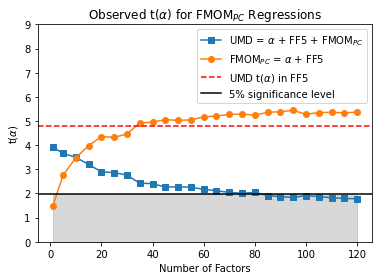

In [287]:
# Sample data (replace with your own arrays)
array1 = total_t_alphas_ff5_pca
array2 = total_t_alphas_umd_pca

# Generate x values (indices of the arrays)
n = len(array1)
x = [5*i for i in range(n)]
x[0]=1

# Create the plot
plt.plot(x, array2, label=r'UMD = $\alpha$ + FF5 + FMOM$_{PC}$', marker='s')
plt.plot(x, array1, label=r'FMOM$_{PC}$ = $\alpha$ + FF5', marker='o')


# Add a constant line with value 1.96
constant_value = 4.80
plt.axhline(y=constant_value, color='r', linestyle='--', label=r"UMD t($\alpha$) in FF5")

constant_value = 1.97
plt.axhline(y=constant_value, color='black', linestyle='-', label='5% significance level')
# Shade the area below the constant line
plt.fill_between(x, 0, constant_value, color='gray', alpha=0.3)

# Add labels and title
plt.xlabel('Number of Factors')
plt.ylabel(r"t($\alpha$)")
plt.title(r"Observed t($\alpha$) for FMOM$_{PC}$ Regressions")

# Show legend
plt.legend()

plt.ylim(0, 9) 

# Display the plot
plt.show()

For each subset, compute regressions for FMOM_ind

In [226]:
# Iterate through subsets by length
total_t_alphas_ff5_ind=[]
total_t_alphas_umd_ind=[]

for key in dicto:
    print(f"Subsets of length {key}:")
    if (key>0 and key%2==0) or key==1:
        t_alphas_ff5_ind=[]
        t_alphas_umd_ind=[]
    
        sample=dicto[key]
            
        for subset in sample:
            subdata=to_trade[subset]
            subtrade=momentum_strategy(subdata)
            
            tval_ff5_ind=ff5_regression(ff5_3,subtrade)
            t_alphas_ff5_ind.append(tval_ff5_ind)
            
            tval_umd_ind=umd_regression(umd,ff5_3,subtrade)
            t_alphas_umd_ind.append(tval_umd_ind)
            
        total_t_alphas_ff5_ind.append(np.mean(t_alphas_ff5_ind))
        print(np.mean(t_alphas_ff5_ind))
        total_t_alphas_umd_ind.append(np.mean(t_alphas_umd_ind))

Subsets of length 1:
1.8673316393980142
Subsets of length 2:
2.5556197499153255
Subsets of length 3:
Subsets of length 4:
2.9863401097049174
Subsets of length 5:
Subsets of length 6:
3.2782815630709963
Subsets of length 7:
Subsets of length 8:
3.745213890911221
Subsets of length 9:
Subsets of length 10:
3.9580875255512615
Subsets of length 11:
Subsets of length 12:
4.098379686521813
Subsets of length 13:
Subsets of length 14:
3.9745067784292005
Subsets of length 15:
Subsets of length 16:
4.335689500545728
Subsets of length 17:
Subsets of length 18:
4.418803987486196
Subsets of length 19:
Subsets of length 20:
4.378754717082678
Subsets of length 21:
Subsets of length 22:
4.514994604472084
Subsets of length 23:
Subsets of length 24:
4.504794582950661
Subsets of length 25:
Subsets of length 26:
4.598434846202901
Subsets of length 27:
Subsets of length 28:
4.652948023717415
Subsets of length 29:
Subsets of length 30:
4.632587530967046
Subsets of length 31:
Subsets of length 32:
4.734598318

**FMOM_ind Results**

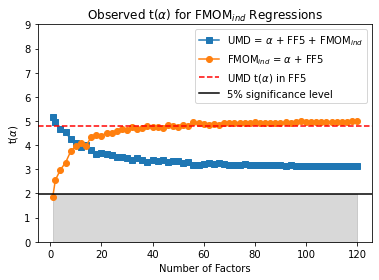

In [288]:
# Sample data (replace with your own arrays)
array1 = total_t_alphas_ff5_ind
array2 = total_t_alphas_umd_ind

# Generate x values (indices of the arrays)
n = len(array1)
x = [2*i for i in range(n)]
x[0]=1

# Create the plot
plt.plot(x, array2, label=r'UMD = $\alpha$ + FF5 + FMOM$_{ind}$', marker='s')
plt.plot(x, array1, label=r'FMOM$_{ind}$ = $\alpha$ + FF5', marker='o')


# Add a constant line with value 1.96
constant_value = 4.80
plt.axhline(y=constant_value, color='r', linestyle='--', label=r"UMD t($\alpha$) in FF5")

constant_value = 1.97
plt.axhline(y=constant_value, color='black', linestyle='-', label='5% significance level')
# Shade the area below the constant line
plt.fill_between(x, 0, constant_value, color='gray', alpha=0.3)

# Add labels and title
plt.xlabel('Number of Factors')
plt.ylabel(r"t($\alpha$)")
plt.title(r"Observed t($\alpha$) for FMOM$_{ind}$ Regressions")

# Show legend
plt.legend()
plt.ylim(0, 9) 

# Display the plot
plt.show()

## 5.5. Do Firm-Specific Returns Display Momentum?

Functions to compute residuals

In [227]:
def capm_regression_rolling(group):
    residuals = []
    dates = group['yyyymm'].unique()
    for i in range(len(dates)):
        if i < 36:  # Skip the first 72 months since we need at least t-72 to t-13 data
            residuals.append(None)
        else:
            # Define the rolling window (t-72 to t-13)
            index=min(i,72)
            window = group[group['yyyymm'].isin(dates[i-index:i-13])]

            # Prepare the independent variables (Fama-French 3 factors) and dependent variable
            X = window[['Mkt-RF']].dropna()
            y = window['ret_exc']

            # Drop missing values in both X and y
            X = sm.add_constant(X)
            y = y.dropna()

            # Align X and y to have the same indices
            y, X = y.align(X, join="inner", axis=0)
            
            if len(y) > 0 and len(X) > 0:
                model = sm.OLS(y, X).fit()
                
                current = group[group['yyyymm'].isin(dates[i-12:i-2])]
                X_curr = current[['Mkt-RF']].dropna()
                y_curr = current['ret_exc'].dropna()

                # Drop missing values in both X and y
                X_curr = sm.add_constant(X_curr)

                # Align X and y to have the same indices
                y_curr, X_curr = y_curr.align(X_curr, join="inner", axis=0)
                
                predicted= model.predict(X_curr)
                resid= y_curr.values - predicted.values

                # Store the residual of the current observation
                rff=np.mean(resid)
                residuals.append(rff)
            else:
                residuals.append(None)
  

    # Add the residuals to the group DataFrame
    group["CAPM_residual"] = residuals
    return group


def ff3_regression_rolling(group):
    residuals = []
    dates = group['yyyymm'].unique()
    for i in range(len(dates)):
        if i < 36:  # Skip the first 72 months since we need at least t-72 to t-13 data
            residuals.append(None)
        else:
            index=min(i,72)
            # Define the rolling window (t-72 to t-13)
            window = group[group['yyyymm'].isin(dates[i-index:i-13])]

            # Prepare the independent variables (Fama-French 3 factors) and dependent variable
            X = window[['Mkt-RF', 'market_equity', 'be_me']].dropna()
            y = window['ret_exc']

            # Drop missing values in both X and y
            X = sm.add_constant(X)
            y = y.dropna()

            # Align X and y to have the same indices
            y, X = y.align(X, join="inner", axis=0)
            
            if len(y) > 0 and len(X) > 0:
                model = sm.OLS(y, X).fit()
                
                current = group[group['yyyymm'].isin(dates[i-12:i-2])]
                X_curr = current[['Mkt-RF', 'market_equity', 'be_me']].dropna()
                y_curr = current['ret_exc'].dropna()

                # Drop missing values in both X and y
                X_curr = sm.add_constant(X_curr)

                # Align X and y to have the same indices
                y_curr, X_curr = y_curr.align(X_curr, join="inner", axis=0)
                
                predicted= model.predict(X_curr)
                resid= y_curr.values - predicted.values

                # Store the residual of the current observation
                rff=np.mean(resid)
                residuals.append(rff)
            else:
                residuals.append(None)
  

    # Add the residuals to the group DataFrame
    group["FF3_residual"] = residuals
    return group

def ff5_regression_rolling(group):
    residuals = []
    dates = group['yyyymm'].unique()
    for i in range(len(dates)):
        if i < 36:  # Skip the first 72 months since we need at least t-72 to t-13 data
            residuals.append(None)
        else:
            # Define the rolling window (t-72 to t-13)
            index=min(i,72)
            window = group[group['yyyymm'].isin(dates[i-index:i-13])]

            # Prepare the independent variables (Fama-French 3 factors) and dependent variable
            X = window[['Mkt-RF', 'market_equity', 'be_me', 'ope_bel1', 'at_gr1']].dropna()
            y = window['ret_exc']

            # Drop missing values in both X and y
            X = sm.add_constant(X)
            y = y.dropna()

            # Align X and y to have the same indices
            y, X = y.align(X, join="inner", axis=0)
            
            if len(y) > 0 and len(X) > 0:
                model = sm.OLS(y, X).fit()
                
                current = group[group['yyyymm'].isin(dates[i-12:i-2])]
                X_curr = current[['Mkt-RF', 'market_equity', 'be_me', 'ope_bel1', 'at_gr1']]
                X_curr = sm.add_constant(X_curr,has_constant='add')
                y_curr = current['ret_exc']
        
                # Align X and y to have the same indices
                y_curr, X_curr = y_curr.align(X_curr, join="inner", axis=0)
            
                predicted= model.predict(X_curr)
                resid= y_curr.values - predicted.values

                # Store the residual of the current observation
                rff=np.mean(resid)
                residuals.append(rff)
            else:
                residuals.append(None)
  

    # Add the residuals to the group DataFrame
    group["FF5_residual"] = residuals
    return group

In [228]:
#Get test stocks
residual_characteristics=stocks[["ret_exc_lead1m","ret_exc","id","yyyymm","market_equity","be_me","ope_bel1","at_gr1","ret_12_2","resff3_12_1","resff3_6_1"]].dropna()

#Join on MKTRF for regression
df1=anomalies[["Mkt-RF"]].dropna()
df1_reset = df1.reset_index()
df1_reset.rename(columns={'index': 'yyyymm'}, inplace=True)

# Merge the DataFrames on 'yyyymm'
merged_df1 = pd.merge(residual_characteristics, df1_reset, on='yyyymm', how='left').dropna()

#compute residuals
df_with_residuals = merged_df1.groupby('id').apply(capm_regression_rolling)
df_with_residuals = df_with_residuals.groupby('id').apply(ff3_regression_rolling)
df_with_residuals = df_with_residuals.groupby('id').apply(ff5_regression_rolling)
df_with_residuals=df_with_residuals.dropna()

In [229]:
residual=["ret_12_2","resff3_12_1","resff3_6_1"]

residual_momentum=pd.DataFrame(columns=residual)
for target in residual:
    residual_momentum[target]=create_momentum(df_with_residuals,target)

residual_momentum["FMOMPC"]=fmom_pca_full
residual_momentum["FMOMFACT"]=fmom_ind_full

residual_momentum["CAPM"]=create_momentum(df_with_residuals,"CAPM_residual") #CAPM t-2 to t-12
residual_momentum["FF3"]=create_momentum(df_with_residuals,"FF3_residual")
residual_momentum["FF5"]=create_momentum(df_with_residuals,"FF5_residual")

**Explanatory: FMOM**

In [295]:
print(residual_momentum.mean())

ret_12_2       0.429558
resff3_12_1    0.437983
resff3_6_1     0.134539
FMOMPC         0.100110
FMOMFACT       0.175267
CAPM           0.406771
FF3            0.228039
FF5            0.137511
dtype: float64


In [296]:
t_stat, p_value = stats.ttest_1samp(residual_momentum, 0)
print(t_stat)

[2.06780383 4.11413902 1.27951358        nan 3.25731992 2.76199791
 2.30266288 1.69151801]


In [308]:
for col in residual + ["CAPM","FF3","FF5"]:
    print(col)
    y = residual_momentum[col].dropna()
    
    explanatory_var=["FMOMFACT","FMOMPC"]
    for mom in explanatory_var:
        #Regression FMOM
        print("Regression where explanatory:", mom)
        X = sm.add_constant(ff5_3.join(total_momentum[[mom]])).dropna()
        y,X=y.align(X,join="inner",axis=0) 
        model = sm.OLS(y, X)
        results = model.fit()

        # Extract the coefficient and t-value for the constant term
        const_coef = results.params['const']
        const_tvalue = results.tvalues['const']
        beta_coef = results.params[mom]
        beta_tvalue = results.tvalues[mom]

        # Print the results
        print(f"Constant: Coefficient = {const_coef:.2f}, T-value = {const_tvalue:.2f}")
        print(f"Betas: Coefficient = {beta_coef:.2f}, T-value = {beta_tvalue:.2f}")
        print(".............")

ret_12_2
Regression where explanatory: FMOMFACT
Constant: Coefficient = 0.17, T-value = 1.20
Betas: Coefficient = 2.24, T-value = 12.97
.............
Regression where explanatory: FMOMPC
Constant: Coefficient = 0.02, T-value = 0.16
Betas: Coefficient = 4.90, T-value = 12.07
.............
resff3_12_1
Regression where explanatory: FMOMFACT
Constant: Coefficient = 0.30, T-value = 3.13
Betas: Coefficient = 0.98, T-value = 8.44
.............
Regression where explanatory: FMOMPC
Constant: Coefficient = 0.27, T-value = 2.55
Betas: Coefficient = 1.99, T-value = 7.29
.............
resff3_6_1
Regression where explanatory: FMOMFACT
Constant: Coefficient = -0.00, T-value = -0.01
Betas: Coefficient = 0.80, T-value = 6.48
.............
Regression where explanatory: FMOMPC
Constant: Coefficient = -0.05, T-value = -0.46
Betas: Coefficient = 1.65, T-value = 5.71
.............
CAPM
Regression where explanatory: FMOMFACT
Constant: Coefficient = 0.23, T-value = 1.99
Betas: Coefficient = 1.66, T-value = 12

# 6. Momentum vis a vis with other factors

## 6.1 Unconditional and Conditional Correlations with UMD

Compute correlations

In [298]:
def tanh(x):
    return (np.log(1+x)/np.log(1-x))/2

#given column wiht factor and column with WML compute corr
def conditional_correlation(factor,mom,sign):
    column=factor.columns[0]
    factor=factor.join(mom)
    if sign==0:
        corr= factor.corr()
        return corr.iloc[0,1]
    
    factor["Prior"]=factor[column].add(1).rolling(window=12).apply(np.prod, raw=True) - 1
    factor=factor.dropna()
    
    if sign>0:
        factor = factor[factor['Prior'] > 0]
    elif sign<0:
        factor = factor[factor['Prior'] < 0]
        
    factor = factor.drop(columns=["Prior"])
    corr=factor.corr()
    n=factor.shape
    return corr.iloc[0,1], n[0]

def correlations(data):
    mom=data[["WML"]]/100
    gmom=data[["gWML"]]/100

    positive=[]
    n_pos=[]
    negative = []
    n_neg = []
    unconditional=[]
    
    test= []
    for col in data.columns:
        #european
        if col!="WML" and col[0]!="g":
            corre1,n1=conditional_correlation(data[[col]]/100,mom,1)
            corre2,n2 = conditional_correlation(data[[col]] / 100, mom, -1)
            corre3= conditional_correlation(data[[col]] / 100, mom, 0)
            
        #global
        if col!="gWML" and col[0]=="g":
            corre1,n1=conditional_correlation(data[[col]]/100,gmom,1)
            corre2,n2 = conditional_correlation(data[[col]] / 100, gmom, -1)
            corre3= conditional_correlation(data[[col]] / 100, gmom, 0)

        if col!="WML" and col !="gWML":
            positive.append(corre1)
            n_pos.append(n1)
            negative.append(corre2)
            n_neg.append(n2)
            unconditional.append(corre3)
            part1=np.sqrt((n1-3)+(n2-3))
            part2=tanh(corre1)-tanh(corre2)
            test.append(part1*part2)
    return np.array(positive), np.array(negative), np.array(unconditional), np.array(test)



results1=correlations(anomalies.drop(columns=["Mkt-RF"]))
results2=correlations(factors2)

print("Positive")
array= (results1[0]+results2[0])/2
# Convert the array to a formatted string, each element on a new line
formatted_array = '\n'.join([f'{item:.2f}' for item in array])
print(formatted_array)
print("Mean",array.mean())

print("Neg")
array= (results1[1]+results2[1])/2
# Convert the array to a formatted string, each element on a new line
formatted_array = '\n'.join([f'{item:.2f}' for item in array])
print(formatted_array)
print("Mean",array.mean())

print("Neutral")
array= (results1[2]+results2[2])/2
# Convert the array to a formatted string, each element on a new line
formatted_array = '\n'.join([f'{item:.2f}' for item in array])
print(formatted_array)
print("Mean",array.mean())

print("Z-test")
array= (results1[3]+results2[3])/2
# Convert the array to a formatted string, each element on a new line
formatted_array = '\n'.join([f'{item:.2f}' for item in array])
print(formatted_array)
print("Mean",array.mean())

Positive
0.17
-0.26
0.54
0.21
-0.25
-0.34
-0.44
0.57
0.69
0.10
-0.05
0.35
0.25
0.09
0.03
0.28
0.61
0.44
Mean 0.16594501600288233
Neg
-0.19
-0.77
-0.04
-0.53
-0.71
-0.75
-0.69
0.12
0.30
-0.29
-0.78
-0.42
-0.62
-0.70
-0.74
-0.69
-0.24
-0.00
Mean -0.43045933226015676
Neutral
-0.02
-0.51
0.41
-0.10
-0.46
-0.50
-0.54
0.44
0.60
-0.08
-0.44
0.09
-0.13
-0.31
-0.33
-0.24
0.24
0.34
Mean -0.08438477079843608
Z-test
3.62
11.52
5.03
9.40
9.74
10.34
6.38
3.41
2.66
4.31
16.37
9.04
12.16
13.54
15.17
14.61
7.38
3.63
Mean 8.794502957065259


## 6.2 Momentum in Momentum-Neutral Factors

In [ ]:
Compute Neutral Weights Factors

In [299]:
#given characteristic and date rank stocks
def rank_neutral(stocks,characteristics, date):
    factors=pd.DataFrame(columns=characteristics)
    
    #stocks at that date
    subset=stocks[stocks["yyyymm"]==date]
    
    subset["safe_ret12"]=subset["ret_12_2"]
    #rank characteristics at a given date
    subset[characteristics]=subset[characteristics].rank()
    subset[characteristics]=subset[characteristics]/(subset[characteristics].max()+1) 

    
    #normalize
    num=subset[characteristics]-subset[characteristics].mean() #center
    den=np.abs(num).sum(axis=0) #absolut deviations
    subset[characteristics]=num/den
    
    #replace nan by 0
    subset[characteristics]=subset[characteristics].fillna(0) #THESE ARE WEIGHTS

    
    #COMPUTE ORTHOGONAL
    for factor in characteristics:
        y=subset[factor]
        X=sm.add_constant(subset["safe_ret12"]).dropna()
        X,y=X.align(y,join="inner",axis=0) 

        model = sm.OLS(y, X)
        results = model.fit()
        
        # Get residuals from the model
        residuals = results.resid

        # Assign residuals back to the 'subset' DataFrame
        subset[factor] = residuals
        
    
    
    #compute month t return using weight t-1
    for charac in characteristics:
        factor=(subset["ret_exc_lead1m"]*subset[charac]).sum()
        factors.loc[date,charac]=factor
        
    return factors*100   


#DataFrame with factor based characteristics
factors_charac_neutral=pd.DataFrame(columns=characteristics_original)
for month in stocks["yyyymm"].unique():
    factors_charac_neutral=factors_charac_neutral.append(rank_neutral(stocks,characteristics_original,month))
    
factors_charac_neutral=factors_charac_neutral.shift(1)#function computes score using next month return, but they are appended as current month -> shift
factors_charac_neutral=factors_charac_neutral[factors_charac_neutral.index<=202312]  
factors_charac_neutral=factors_charac_neutral.dropna()
factors_charac_neutral = factors_charac_neutral.apply(pd.to_numeric)

PC factor momentum strategy with Neutral Factors (Same than 3.5)

In [300]:
factors_pca_neutral=factors_charac_neutral.drop(columns=momentum_char+others)
to_remove=factors_pca_neutral.columns[(factors_pca_neutral == 0).any(axis=0)]
factors_pca_neutral= factors_pca_neutral.drop(columns=to_remove)
factors_pca_neutral= factors_pca_neutral.dropna()

dataset=factors_pca_neutral.copy()

start_index=60
returns_neutral = pd.DataFrame(index=dataset.index[start_index:], columns=[0,25, 50,75,100,120])
month_list=dataset.index
pc_factors=pd.DataFrame(columns = [str(i) for i in range(1, len(dataset.columns)+1)]) #floats
for t in range(start_index, len(dataset)):
    #Dataset starts 199008 -> First month 199507: first month with 60month of data
    current_month=month_list[t-1]
    next_month=month_list[t]


    #1)Compute eigenvectors using returns up to end of month t
    #data up to month t (up to 199507)
    data=dataset.loc[:current_month]
    
    # Standardize the data
    scaler = StandardScaler()
    data_standarized = scaler.fit_transform(data) 
 
    correlation_matrix = np.corrcoef(data_standarized, rowvar=False)
    correlation_matrix[np.isnan(correlation_matrix)] = 0
    
    pca = PCA()
    pca.fit(correlation_matrix)
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    
    ## 2. Compute monthly returns for the PC in month t + 1 (199508)
    
    #a) RECOMPUTE EVERYTHINGH UP TO T+1: PC factors start at 199008
    pc_returns = np.dot(dataset.iloc[:t + 1], eigenvectors.T) #also includes next month returns
    
    pc_returns_df = pd.DataFrame(pc_returns, index=dataset.index[:t + 1],columns=[str(i) for i in range(1, len(dataset.columns)+1)])

    ## 3.Individual factor variances up to month t (200909)
    individual_variances=data.var()
        
    #Deamean an lever pc_factors (up to month t or t+1??)
    in_sample=pc_returns_df.copy() #it is different (demeaned and levered for each month)
    in_sample=in_sample.drop(in_sample.index[-1])#drop t+1 returns
    
    levered=demean_and_lever(in_sample, individual_variances)          
            
            
    #4) Trade based on insample (we need 12 months of prior data)
    next_month_returns=pc_returns_df.tail(1) #200010
    n_factors=[0,25,50,75,100,120]

    next_month_returns=factor_momentum_strategy(in_sample,next_month_returns,n_factors)
    
    returns_neutral.loc[next_month,:]=next_month_returns

**Print results**

In [301]:
print(returns_neutral.mean())

t_test_results = {}

# Iterate over each column and perform the T-test
for column in returns_neutral.columns:
    t_value, p_value = stats.ttest_1samp(pd.to_numeric(returns_neutral[column]), popmean=0)
    t_test_results[column] = {'T-value': t_value, 'P-value': p_value}

# Print the T-values and P-values for each column
for column, results in t_test_results.items():
    print(f"Column: {column}")
    print(f"T-value: {results['T-value']}, P-value: {results['P-value']}\n")

0      0.287971
25     0.086134
50     0.041402
75     0.021982
100    0.014080
120    0.091988
dtype: float64
Column: 0
T-value: 5.337330671132995, P-value: 1.7273137216946979e-07

Column: 25
T-value: 4.774903883570704, P-value: 2.6764749848831615e-06

Column: 50
T-value: 3.033645802412051, P-value: 0.002602148351621908

Column: 75
T-value: 2.240903357460685, P-value: 0.025677450067105926

Column: 100
T-value: 1.5679963209559362, P-value: 0.11781216826967641

Column: 120
T-value: 5.598027483215222, P-value: 4.4723594362251726e-08



**Target: Original & Neutral PCA. Explanatory: FF5**

In [303]:
returns_neutral = returns_neutral.apply(pd.to_numeric)
returns = returns.apply(pd.to_numeric)
target=[returns,returns_neutral]
for tar in target:
    
    X=sm.add_constant(ff5_3)
    y=tar[120]
    X,y=X.align(y,join="inner",axis=0) 

    model = sm.OLS(y, X)
    results = model.fit()

    print("Alpha")
    print(results.params["const"])
    print(results.tvalues["const"])
    print(results.rsquared*100)


Alpha
0.10661849519683934
5.308648449395786
44.00508954824658
Alpha
0.09080900597214081
6.078739926437045
26.827944310122355


**Target: Original PC. Explanatory: Neutral PC + FF5**

In [305]:
X=sm.add_constant(ff5_3.join(returns_neutral[120]))
y=returns[120]
X,y=X.align(y,join="inner",axis=0) 

model = sm.OLS(y, X)
results = model.fit()

print("Alpha")
print(results.params["const"])
print(results.tvalues["const"])

print("Coefficient")
print(results.params[120])
print(results.tvalues[120])

print(results.rsquared*100)

Alpha
0.008849858676083441
0.6972114855532535
Coefficient
1.0766403119834855
24.437518560475123
79.91574906505788


**Target: Neutral PC. Explanatory: Original PC + FF5**

In [306]:
X=sm.add_constant(ff5_3.join(returns[120]))
y=returns_neutral[120]
X,y=X.align(y,join="inner",axis=0) 

model = sm.OLS(y, X)
results = model.fit()

print("Alpha")
print(results.params["const"])
print(results.tvalues["const"])

print("Coefficient")
print(results.params[120])
print(results.tvalues[120])

print(results.rsquared*100)

Alpha
0.027299791863937523
2.9261841984463075
Coefficient
0.5956678903688557
24.437518560475112
73.75465169879483
